# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../../')

%run ../../../setup_project.py
%run ../../../generic_plot_functions.py
%run ../../../path_reconstruction/functions.py


from leverReconstructionFunctions import *
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import remainder, tau
import math
from scipy import stats
from statannotations.Annotator import Annotator
import collections
from matplotlib.colors import LinearSegmentedColormap

In [2]:
sns.__version__

'0.12.2'

# Preparations

In [3]:
projectName, dataPath, dlcModelPath, myProject, sSessions= setup_project_session_lists()

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /adata/projects/autopi_mec
dlcModelPath: /adata/models
Reading /adata/projects/autopi_mec/sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [4]:
prepareSessionsForSpatialAnalysisProject(sSessions,myProject.sessionList)

Loading Animal_pose and Spike_train, sSes.ap and sSes.cg
Will load .pose.npy


100%|██████████| 180/180 [08:37<00:00,  2.88s/it]


Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [5]:
def nested_dict():
    return collections.defaultdict(nested_dict)

boxprops = {'edgecolor': 'k', 'linewidth': 1.5}
lineprops = {'color': 'k', 'linewidth': 1.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                   'whiskerprops': lineprops, 'capprops': lineprops,
                   'width': 0.75})
stripplot_kwargs = dict({'linewidth': 1, 'size': 7, 'alpha': 0.8},)

colors = ['#ff0080','#3f5efb','#40e0d0','#ff8c00','#ff0080']

cmap = LinearSegmentedColormap.from_list('custom',colors)

color_map_hue = 'leverAngle' 

GLOBALFONTSIZE = 13

In [6]:
fp = 'shuffled_lever_grid_coordintates_speed_adjust_24sessions_speed_above_10.pickle'

with open(fp, 'rb') as file:
    shuffleData = pickle.load(file)

In [7]:
def get_shuffled_stats(lc = 'atLever_dark',param='shuffled'):
    shuffleHolder = []
    sesHolder = []
    light_condition = lc
    for s in shuffleData.keys():
        sd = shuffleData[s][light_condition][param]
        shuffleHolder.append(sd)
        sesHolder.append(s)

    shuffleLightDf = pd.DataFrame(np.array([shuffleHolder]),columns=sesHolder)
    longDf = shuffleLightDf.melt(var_name = 'Session', value_name = 'Values')
    longDf['light'] = light_condition
    return longDf

In [8]:
shuffleStatsDf = pd.concat([get_shuffled_stats('atLever_dark','predicted'),get_shuffled_stats('atLever_light','predicted')])

In [9]:
useAble = ['jp486-19032023-0108', 'jp486-18032023-0108',
       'jp3269-28112022-0108', 'jp486-16032023-0108',
       'jp452-25112022-0110', 'jp486-24032023-0108',
       'jp486-22032023-0108', 'jp452-24112022-0109',
       'jp486-15032023-0108', 'jp3120-25052022-0107',
       'jp3120-26052022-0107', 'jp451-28102022-0108',
       'jp486-20032023-0108', 'jp486-06032023-0108',
       'jp486-26032023-0108', 'jp486-17032023-0108',
       'jp451-29102022-0108', 'jp451-30102022-0108',
       'jp486-10032023-0108', 'jp486-05032023-0108',
       'jp3269-29112022-0108', 'mn8578-17122021-0107',
       'jp452-23112022-0108', 'jp1686-26042022-0108']

In [10]:
allSessionDf = pd.read_csv('~/repo/analysis_jingjie/jingjie/autopi_mec_jingjie_csv_data/allSessionDf_with_leverVector_and_last_cohort.csv',index_col=0) 
allSessionDf['distanceToArenaCenter'] = np.sqrt(allSessionDf['xPose']**2 + allSessionDf['yPose']**2)

In [11]:
from matplotlib.colors import Normalize

hue_min = allSessionDf['leverAngle'].min()
hue_max = allSessionDf['leverAngle'].max()
GLOBALHUENORM = Normalize(vmin=hue_min, vmax=hue_max)

In [12]:
import matplotlib.patches as patches

arenaBorderColor= '#BAD7E9'
def draw_circle(ax, r=44, edge_color=arenaBorderColor, center=(0, 0), lw=2, ls='solid'):
    circle = plt.Circle(center, r, edgecolor=edge_color, facecolor='none', lw=lw, linestyle=ls, alpha=1)
    ax.add_patch(circle)
    ax.set_aspect('equal')
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)
def plot_leverPath(ax,df,condition = 'atLever_dark',predicted=False,color_map_hue = 'leverAngle',simple=False,title='',ylabel=''):
    
    if predicted:
        b = sns.scatterplot(data = df[df.condition == condition], x = 'ActualCoordpx',y = 'ActualCoordpy', s =4,
                            hue = color_map_hue,hue_norm=GLOBALHUENORM,palette=cmap,alpha=1,legend=False) #leverCenterActualpX
    else:    
        b = sns.scatterplot(data = df[df.condition == condition], x = 'xPose',y = 'yPose', s =4,
                            hue = color_map_hue,hue_norm=GLOBALHUENORM,palette=cmap,alpha=1,legend=False) #leverCenterActualX
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Room Coordinate X",fontsize=GLOBALFONTSIZE)
    ax.set_ylabel("Room Coordinate X",fontsize=GLOBALFONTSIZE)
    

    
    ax.set_xlim(-50,50)
    ax.set_ylim(-50,50)
    ax.set_aspect('equal')
    
    if predicted:
        ax.set_title(f'Predicted {condition}',fontsize=GLOBALFONTSIZE)
    else:
        ax.set_title(f'Actual {condition}',fontsize=GLOBALFONTSIZE)
        
    if simple == True:
        if condition == 'atLever_light':
            borderCo = '#f1d18a'
        else:
            borderCo = '#588d9c'
                
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xlabel("")
        ax.set_ylabel(ylabel, labelpad = 30,fontsize=GLOBALFONTSIZE)
        ax.set_title('')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        #Add the border of the arena
        draw_circle(ax)
        draw_circle(ax,r=40,lw=1,ls='dashed')
        #circle = patches.Circle((0, 0), radius=44, edgecolor=borderCo,lw=5, facecolor='none',linestyle='dashed',alpha = 0.6)
        #ax.add_patch(circle)
        
        ax.set_title(f"{title}",fontsize=GLOBALFONTSIZE)

        
def plot_leverCenter(ax,df,condition = 'atLever_dark',predicted=False,color_map_hue = 'leverAngle'):
    
    if predicted:
        b = sns.scatterplot(data = df[df.condition == condition], x = 'leverCenterActualpX',y = 'leverCenterActualpY', s =1,hue = color_map_hue,hue_norm=GLOBALHUENORM,
                            palette=cmap,alpha=1,legend=False) #leverCenterActualpX
    else:    
        b = sns.scatterplot(data = df[df.condition == condition], x = 'leverCenterX',y = 'leverCenterY', s =1,hue = color_map_hue,hue_norm=GLOBALHUENORM,
                            palette=cmap,alpha=1,legend=False) #leverCenterActualX
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Room Coordinate X")
    ax.set_ylabel("Room Coordinate X")
    
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    if predicted:
        ax.set_title(f'Predicted {condition}')
    else:
        ax.set_title(f'Actual {condition}')

def plot_full_gridCoord(ax,df,c ='atLever_dark',predicted = True,double=False,color_map_hue='leverAngle',simple=False, negativeToPositive=False,ylabel = ''):
    
    trialDf = df[df.condition == c].copy()
    
    if double:
        v0,v1 = get_double_v(trialDf,predicted=predicted)
        vCoordinates = pd.DataFrame(np.array([v0,v1,list(trialDf[color_map_hue])*4]).T,columns = ['v0','v1',color_map_hue])
    else:
        v0,v1 = get_v(trialDf,predicted=predicted)
        vCoordinates = pd.DataFrame(np.array([v0,v1,trialDf[color_map_hue]]).T,columns = ['v0','v1',color_map_hue])


    
    colorMap = cmap
    
    mask = (vCoordinates.v0 < np.pi*2)&(vCoordinates.v0 >= 0)&(vCoordinates.v1 < np.pi*2)&(vCoordinates.v1 >= 0)
    
    if negativeToPositive:
        mask = (vCoordinates.v0 < np.pi)&(vCoordinates.v0 >= -np.pi)&(vCoordinates.v1 < np.pi)&(vCoordinates.v1 >= -np.pi)
    
    a = sns.scatterplot(data=vCoordinates[mask],x = 'v0',y = 'v1',hue = color_map_hue, palette = colorMap, ax = ax,legend=False,s = 2,alpha = 1)

    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Grid Coordinate X")
    ax.set_ylabel("Grid Coordinate Y")
    
    ax.set_aspect('equal')
    if not double:
        ax.set_xticks(ticks=[-np.pi, 0, np.pi])
        ax.set_xticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, 0, np.pi])
        ax.set_yticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    
    else:
        ax.set_xticks(ticks=[-np.pi, 0, 3*np.pi])
        ax.set_xticklabels([r'-$\pi$', "0", "3$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, 0, 3*np.pi])
        ax.set_yticklabels([r'-$\pi$', "0", "3$\pi$"],fontsize=GLOBALFONTSIZE)
        
    if double:
        d = 'LOOPED'
    else:
        d = ''
    
    if predicted:
        ax.set_title(f'{d} Predicted Grid, {c}',fontsize=GLOBALFONTSIZE)
    else: 
        ax.set_title(f'{d} Actual Grid, {c}',fontsize=GLOBALFONTSIZE)
        
    if simple:
        ax.set_xticks(ticks=[0, 2*np.pi])
        ax.set_xticklabels(["0","2$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[0,2*np.pi])
        ax.set_yticklabels(["0", "2$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_xlim(0,2*np.pi)
        ax.set_ylim(0,2*np.pi)
        
        #ax.spines['left'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
        
        ax.set_xlabel("")
        ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
        ax.set_title('')
        
    if negativeToPositive:
        ax.set_xticks(ticks=[-np.pi, np.pi])
        ax.set_xticklabels(["-$\pi$", "$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, np.pi])
        ax.set_yticklabels(["-$\pi$", "$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_xlim(-np.pi, np.pi)
        ax.set_ylim(-np.pi, np.pi)
        
def plot_lever_full_gridCoord(ax,df,c ='atLever_dark',predicted = True,double=False,stack= False,simple=False, negativeToPositive=False,ylabel = ''):
    trialDf = df[df.condition == c].copy()
    if double:
        v0,v1 = get_double_lever_v(trialDf,predicted=predicted)
        vCoordinates_l = pd.DataFrame(np.array([v0,v1,list(trialDf[color_map_hue])*4]).T,columns = ['v0_l','v1_l',color_map_hue])
    else:
        v0,v1 = get_lever_v(trialDf,predicted=predicted)
        vCoordinates_l = pd.DataFrame(np.array([v0,v1,trialDf[color_map_hue]]).T,columns = ['v0_l','v1_l',color_map_hue])
    if double:
        v0,v1 = get_double_v(trialDf,predicted=predicted)
        vCoordinates = pd.DataFrame(np.array([v0,v1,list(trialDf[color_map_hue])*4]).T,columns = ['v0','v1',color_map_hue])
    else:
        v0,v1 = get_v(trialDf,predicted=predicted)
        vCoordinates = pd.DataFrame(np.array([v0,v1,trialDf[color_map_hue]]).T,columns = ['v0','v1',color_map_hue])
    colorMap = cmap
    #a = sns.scatterplot(data=vCoordinates_l,x = 'v0_l',y = 'v1_l', ax = ax,legend=False,s = 10)
    
    mask = (vCoordinates_l.v0_l < np.pi*2)&(vCoordinates_l.v0_l >= 0)&(vCoordinates_l.v1_l < np.pi*2)&(vCoordinates_l.v1_l >= 0)
    
    if negativeToPositive:
        mask = (vCoordinates_l.v0_l < np.pi)&(vCoordinates_l.v0_l >= -np.pi)&(vCoordinates_l.v1_l < np.pi)&(vCoordinates_l.v1_l >= -np.pi)

    a = sns.kdeplot(data=vCoordinates_l,x = 'v0_l',y = 'v1_l',alpha = 1, fill=True, ax = ax)
    
    if stack:
        a = sns.scatterplot(data=vCoordinates,x = 'v0',y = 'v1',hue = color_map_hue, palette = colorMap, ax = ax,legend=False,s = 5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Grid Coordinate X",fontsize=GLOBALFONTSIZE)
    ax.set_ylabel("Grid Coordinate Y",fontsize=GLOBALFONTSIZE)
    ax.set_aspect('equal')
    if not double:
        ax.set_xticks(ticks=[-np.pi, 0, np.pi])
        ax.set_xticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, 0, np.pi])
        ax.set_yticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    else:
        ax.set_xticks(ticks=[-np.pi, 0, 3*np.pi])
        ax.set_xticklabels([r'-$\pi$', "0", "3$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, 0, 3*np.pi])
        ax.set_yticklabels([r'-$\pi$', "0", "3$\pi$"],fontsize=GLOBALFONTSIZE)
    if double:
        d = 'LOOPED'
    else:
        d = ''
    if predicted:
        ax.set_title(f'{d} Predicted Grid, {c}',fontsize=GLOBALFONTSIZE)
    else:
        ax.set_title(f'{d} Actual Grid, {c}',fontsize=GLOBALFONTSIZE)
        
    if simple:
        ax.set_xticks(ticks=[0, 2*np.pi])
        ax.set_xticklabels(["0", "2$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[0, 2*np.pi])
        ax.set_yticklabels(["0", "2$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_xlim(0,2*np.pi)
        ax.set_ylim(0,2*np.pi)
        ax.set_title('')
        ax.set_xlabel("")
        ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
        
    if negativeToPositive:
        ax.set_xticks(ticks=[-np.pi, np.pi])
        ax.set_xticklabels(["-$\pi$", "$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, np.pi])
        ax.set_yticklabels(["-$\pi$", "$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_xlim(-np.pi, np.pi)
        ax.set_ylim(-np.pi, np.pi)

# Vector to lever or bridge

In [13]:
fn = myProject.dataPath+"/results/cells.csv"

print("Loading", fn)
cells = pd.read_csv(fn)

def get_lever_vector_gridCoord(sessionName,cells,sSessions,inputDf):
    """
    Function used to transform the xy to v0,v1,v2 coordinate system for a session
    The direction and period of v0,v1,v2 depend on the grid cells recorded in this session.
    We get the grid parameter from .grid_cells_parameters.pkl
    """
    #Create the toLeverVector
    toLeverVector = np.array(inputDf[['vectorToLever_x','vectorToLever_y']])
    
    # load session files
    sSes, ap, apSim, cg = load_session_files_for_modelling(sessionName,cells,sSessions)

    verbose = False
    # load grid cell parameters
    fn = sSes.fileBase+".grid_cell_parameters.pkl"
    if verbose:
        print("Loading:",fn)
    with open(fn, 'rb') as fp: 
        params = pickle.load(fp)
    oriRigid = np.stack([p["grid_param_model_rigid"]["orientation"] for p in params])
    oriFlexible = np.stack([p["grid_param_model_flexible"]["orientation"] for p in params])
    periodRigid = np.stack([p["grid_param_model_rigid"]["period"] for p in params])
    periodFlexible = np.stack([p["grid_param_model_flexible"]["period"] for p in params])


    grid_param_transformation = {
    "period": np.median(periodFlexible,axis=0),
    "orientation": np.median(oriFlexible,axis=0),
    }

    if verbose:
        print(grid_param_transformation)

    gt = gridTransformation(period = grid_param_transformation["period"],
                           orientation = grid_param_transformation["orientation"])

    gridSpacePose = gt.poseToGridSpace(pose=np.array(toLeverVector))
    v0 = np.arctan2(gridSpacePose[:,1],gridSpacePose[:,0])
    v1 = np.arctan2(gridSpacePose[:,3],gridSpacePose[:,2])
    
    return v0, v1

def get_bridge_vector_gridCoord(sessionName,cells,sSessions,inputDf):
    """
    Function used to transform the xy to v0,v1,v2 coordinate system for a session
    The direction and period of v0,v1,v2 depend on the grid cells recorded in this session.
    We get the grid parameter from .grid_cells_parameters.pkl
    """
    #Create the toLeverVector
    toLeverVector = np.array(inputDf[['vectorToBridge_x','vectorToBridge_y']])
    
    # load session files
    sSes, ap, apSim, cg = load_session_files_for_modelling(sessionName,cells,sSessions)

    verbose = False
    # load grid cell parameters
    fn = sSes.fileBase+".grid_cell_parameters.pkl"
    if verbose:
        print("Loading:",fn)
    with open(fn, 'rb') as fp: 
        params = pickle.load(fp)
    oriRigid = np.stack([p["grid_param_model_rigid"]["orientation"] for p in params])
    oriFlexible = np.stack([p["grid_param_model_flexible"]["orientation"] for p in params])
    periodRigid = np.stack([p["grid_param_model_rigid"]["period"] for p in params])
    periodFlexible = np.stack([p["grid_param_model_flexible"]["period"] for p in params])


    grid_param_transformation = {
    "period": np.median(periodFlexible,axis=0),
    "orientation": np.median(oriFlexible,axis=0),
    }

    if verbose:
        print(grid_param_transformation)

    gt = gridTransformation(period = grid_param_transformation["period"],
                           orientation = grid_param_transformation["orientation"])

    gridSpacePose = gt.poseToGridSpace(pose=np.array(toLeverVector))
    v0 = np.arctan2(gridSpacePose[:,1],gridSpacePose[:,0])
    v1 = np.arctan2(gridSpacePose[:,3],gridSpacePose[:,2])
    
    return v0, v1

Loading /adata/projects/autopi_mec/results/cells.csv


# Put everything in one figure

In [14]:
fn = "/adata/projects/autopi_mec/results/myMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    myMaps = pickle.load(handle)

In [15]:
fn = "/adata/projects/autopi_mec/results/atLever18/myLeverMaps.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
   myLeverMaps = pickle.load(handle)

In [16]:
fn=myProject.dataPath+"/results/myLeverMapsHDInfo_new_function.pickle"
with open(fn, 'rb') as handle:
    HDInfo = pickle.load(handle)
    
fn=myProject.dataPath+"/results/atLever18/myLeverMapsHDInfoShuffle100.pickle"
with open(fn, 'rb') as handle:
    HDInfoShuffle100 = pickle.load(handle)
    

fn=myProject.dataPath+"/results/atLever18/leverMapCor.pickle"
with open(fn, 'rb') as handle:
    leverMapCor = pickle.load(handle)
 
fn=myProject.dataPath+"/results/atLever18/leverIFRDict.pickle"
with open(fn, 'rb') as handle:
    leverIFR = pickle.load(handle)
    


fn=myProject.dataPath+"/results/cells_with_leverCells.csv"
ct = pd.read_csv(fn)


gcIndices=ct["gridCell_FIRST"] 
gcId=ct.cluId[gcIndices]
print("Grid cells: {}".format(np.sum(gcIndices)))
gc=ct.loc[ct["gridCell_FIRST"],:] 
leverGc = ct.loc[ct["gridCell_FIRST"],:] 

Grid cells: 931


In [17]:
cellDict={"light": {"cellIds":["jp1686-26042022-0108_29","jp3129-04062022-0108_340",'mn8578-23122021-0108_141'],
                    "trialLists":([70,16,72],[8,18,48],[117,67,18])},
          "dark": {"cellIds": ["jp3129-04062022-0108_389","jp486-16032023-0108_653",'jp486-26032023-0108_751'],
                   "trialLists":([51,77,89],[91,75,117],[19,35,129])}
         }

In [18]:
def normalize_2d_array(arr):
    """
    Normalize the values in each row of a 2D array to the range [0, 1].

    Parameters:
    arr (list of lists): The input 2D array.

    Returns:
    np.ndarray: The normalized 2D array.
    """
    # Convert the input list of lists to a NumPy array
    np_arr = np.array(arr, dtype=float)

    # Find the minimum and maximum values along each row
    min_vals = np.min(np_arr, axis=1, keepdims=True)
    max_vals = np.max(np_arr, axis=1, keepdims=True)

    # Ensure there are no divisions by zero
    max_vals[max_vals == min_vals] = 1

    # Normalize the array to the range [0, 1]
    normalized_arr = (np_arr - min_vals) / (max_vals - min_vals)

    return normalized_arr

In [19]:
arenaBorderColor= '#BAD7E9'
def draw_circle(ax, r=44, edge_color=arenaBorderColor, center=(0, 0), lw=2, ls='solid'):
    circle = plt.Circle(center, r, edgecolor=edge_color, facecolor='none', lw=lw, linestyle=ls, alpha=1)
    ax.add_patch(circle)
    ax.set_aspect('equal')
    ax.set_xlim(-50, 50)
    ax.set_ylim(-50, 50)

def plotAngularMap(axes, maps,bc='#000000',showYLabel=True):
    histo=gaussian_filter1d(maps['histo'], sigma=2)
    axes.plot(histo,lw=3,color=bc)
    if showYLabel:
        axes.set_ylabel("Firing\nrate (Hz)",fontsize= GLOBALFONTSIZE)
    else:
        axes.set_ylabel("")
        axes.set_yticks([])
        
    
    axes.set_xlabel("")
    axes.set_xticks([])
    [axes.spines[d].set_visible(False) for d in ['top','bottom','right']]
    
def plotLeverIFRMatrix(ax,cellId,light,showXLabel=True,sort=True,showYLabel=True,rowNorm = False):
    """
    Plot the matrix of rate per journey as a function of direction
    """
    m = leverIFR[cellId]["matrix"]['{}_targetToAnimalAngle'.format(light)]
    
    # sort matrix from shortest to longest distance from lever
    if sort:
        m["matrix"]= m["matrix"][np.argsort(-np.sum(np.isnan(m["matrix"]),axis=1))]
    if rowNorm:
        m["matrix"]=normalize_2d_array(m["matrix"])
    
    ax.imshow(m['matrix'],aspect="auto",interpolation="none",extent=[np.min(m["bins"]),np.max(m["bins"]),0,m["matrix"].shape[0]],origin="lower",cmap="viridis")
    
    if showXLabel:
        ax.set_xlabel("Direction",fontsize=GLOBALFONTSIZE)
        ax.set_xticks(ticks=[-np.pi, 0, np.pi])
        ax.set_xticklabels([ "-$\pi$","0", "$\pi$"])
    else:
        ax.set_xlabel("")
        ax.set_xticks([])
        
    if showYLabel:
        ax.set_ylabel("Trials",fontsize=GLOBALFONTSIZE)
    else:
        ax.set_ylabel("")
        ax.set_yticks([])
    #ax.yaxis.set_label_coords(-0.4, 0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.set_aspect('equal')
    

def plotTrialSetup(t,ax=None,title = "", arena=True, bridge=True,homeBase=True,lever=True,leverZones=True, borderColor= '#000000'):
        """
        Function to draw arena, bridge and home base on an axis
        """
        if ax is None:
            ax = plt.gca()

        # to plot the arena circle
        arenaPose=np.arange(start=0,stop=2*np.pi,step=0.02)
        # plot the arena and arena periphery
        ax.set_aspect('equal', adjustable='box')
        ax.set_title(title,fontsize=GLOBALFONTSIZE)
        if arena:
            draw_circle(ax)
            draw_circle(ax,r=40,lw=1,ls='dashed')
            
            ax.set_xlabel("cm")
            ax.set_ylabel("cm")
        zones=[]
        if bridge:
            zones.append("bridge")
        if homeBase:
            zones.append("homeBase")
        if bridge or homeBase:
            for i in zones:
                rect = patches.Rectangle((t.zones[i][0],
                                          t.zones[i][1]), 
                                          t.zones[i][2],
                                          t.zones[i][3], linewidth=1, edgecolor='gray', facecolor='none')
                # Add the patch to the axes
                ax.add_patch(rect)
        if lever:
            
            def plotLever(t,ax=None, zones=True):
                """
                Function to plot the lever on an matplotlib axis
                """
                if ax is None:
                    ax = plt.gca()

                if hasattr(t, 'pointsPlot'):
                    ax.plot(t.pointsPlot[:,0],t.pointsPlot[:,1], color = "#525252",lw=3)
                    if zones:
                        ax.plot(t.enterZonePointsPlot[:,0],t.enterZonePointsPlot[:,1], color = "gray",linestyle="dotted")
                        ax.plot(t.exitZonePointsPlot[:,0],t.exitZonePointsPlot[:,1], color = "gray",linestyle="dotted")
                    
            plotLever(t=t.lever,ax=ax,zones=leverZones)
        return(ax)
    
def plot_correlations(gs,leverMapCor,showLegend=False):
    four_custom = [boxPlotColors[0],boxPlotColors[2]] #'#ffc600'
    ##02304A color black
    custom_pallet = sns.color_palette(four_custom)
    
    ax = fig.add_subplot(gs)

    leverMapCor=leverMapCor.replace('none','Lever ref.')
    leverMapCor=leverMapCor.replace('arenaref','Room ref.')
    b = sns.boxplot(x="condition", y="r", hue = "rotation", data=leverMapCor, palette = custom_pallet, order = ["l1l2","d1d2"], hue_order=['Lever ref.','Room ref.'],
                dodge=True, showfliers = False, **boxplot_kwargs)
    sns.stripplot(x="condition", y="r", hue = "rotation", data=leverMapCor, palette = custom_pallet, order = ["l1l2","d1d2"], hue_order=['Lever ref.','Room ref.'], dodge = True, legend=False,**stripplot_kwargs) #, legend=False
    ax.set_ylabel("Inter-trial map stability",fontsize=GLOBALFONTSIZE)
    ax.set_xlabel("")
    

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(-0.1,1.3)
    
    sns.move_legend(b, 'lower center',
                bbox_to_anchor = (.73,0.81),
                ncol=1,
                title=None,
                frameon=False,
                fontsize = GLOBALFONTSIZE)
    
    pairs=[[("d1d2", "Lever ref."),("d1d2","Room ref.")],[("l1l2", "Lever ref."),("l1l2","Room ref.")]]

    annotator = Annotator(b, pairs, x="condition", y="r", hue = "rotation", data=leverMapCor,order = ["l1l2","d1d2"], hue_order=['Lever ref.','Room ref.'])
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside') #Wilcoxon, Mann-Whitney
    annotator.apply_and_annotate()
    
    ax.set_xticklabels(["Light", "Dark"],rotation= 0,ha = "center",fontsize=GLOBALFONTSIZE)
    
    number = len(leverMapCor.mouse.unique())
    ax.text(0.07,0.95, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)
    
def boxplot_from_shuffle(gs,df_HDInfo,y,ylabel,showLegend=False):
    four_custom = [boxPlotColors[0],boxPlotColors[3]] #'#5800ff'
    custom_pallet = sns.color_palette(four_custom)
    
    ax = fig.add_subplot(gs)
    df_HDInfo=df_HDInfo.replace(False,'Lever ref.')
    df_HDInfo=df_HDInfo.replace(True,'Shuffled')
    b = sns.boxplot(x="light", y=y, hue="shuffle", data=df_HDInfo, order = ["all_light",'all_dark'],dodge=True, showfliers = False,hue_order=['Lever ref.','Shuffled'],
                 palette = custom_pallet, **boxplot_kwargs)
    sns.stripplot(x="light", y=y, hue="shuffle", data=df_HDInfo, order = ["all_light",'all_dark'],hue_order=['Lever ref.','Shuffled'],
                 palette = custom_pallet, dodge = True, legend=False,**stripplot_kwargs) #, legend=False
    
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
    ax.set_xlabel("")
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0,0.6)
    
    sns.move_legend(b, 'lower center',
                bbox_to_anchor = (.73,0.81),
                ncol=1,
                title=None,
                frameon=False,
                fontsize = GLOBALFONTSIZE)
    
    pairs=[[("all_dark", "Lever ref."),("all_dark","Shuffled")],[("all_light", "Lever ref."),("all_light","Shuffled")]]

    print(df_HDInfo)

    annotator = Annotator(b, pairs, x="light", y=y, hue="shuffle", data=df_HDInfo, order = ["all_light",'all_dark'], hue_order=['Lever ref.','Shuffled'])
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside') #Wilcoxon, Mann-Whitney
    annotator.apply_and_annotate()
    
    ax.set_xticklabels(["Light","Dark"],rotation= 0,ha = "center",fontsize=GLOBALFONTSIZE)
    
    number = len(df_HDInfo.mouse.unique())
    ax.text(0.07,0.95, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)

    return df_HDInfo

In [20]:
def spikeOnPathSingleTrial(axes,cluId,trialList,light,borderColor = '#000000'):
    """
    Plot the spikes on the animal path for some trials
    """
    
    if light == 'light':
        myColorList=['#fc8d03','#fc8d03','#fc8d03']
        myColorList=['red','red','red']
    elif light == 'dark':
        myColorList=['#5950e9','#5950e9','#5950e9']
        myColorList=['red','red','red']
    
    sessionName = cluId.split("_")[0]
    cluNumber = cluId.split("_")[1]
    ses = myProject.getSession(sessionName)
    fn=ses.path+"/ses.pickle"
    with open(fn, 'rb') as handle:
        ses=pickle.load(handle)
    sSes = [ s for s in sSessions if s.name == sessionName][0]
    getSearchHomingIntervals(ses,sSes)
    n = [ n for n in sSes.cg.neuron_list if n.name == cluNumber][0]
    
    for i,trialNo in enumerate(trialList):

        t = ses.trialList[trialNo]
        j = t.journeyList[-1]

        if i == 0:
            plotTrialSetup(t, ax = axes,leverZones=False,homeBase=False,bridge=False,borderColor=borderColor)

        else:
            plotTrialSetup(t, ax = axes, arena=False,leverZones=False,homeBase=False,bridge=False,borderColor=borderColor)
            
        inter = np.array([[j.startTime,j.endTime]])

        sSes.ap.unset_intervals()
        inter = RosToResTime(inter.flatten(),np.stack([sSes.ap.pose[:,0],sSes.ap.pose[:,7]],axis=1)).reshape((-1,2))
        n.spike_train.set_intervals(inter)
        sSes.ap.set_intervals(inter)
        n.spatial_properties.spike_posi=n.spatial_properties.spike_position()
        spike_posi=n.spatial_properties.spike_posi
        
        start=[];stop=[]
        for sta,sto in ses.intervalDict[f'atLever_{light}']:
            if sta>=inter[0][0] and sto<=inter[0][1]:
                start.append(sta);stop.append(sto)
        inter2=np.array([[start,stop]]).reshape((-1,2))
        n.spike_train.set_intervals(inter2)
        sSes.ap.set_intervals(inter2)
        n.spatial_properties.spike_posi=n.spatial_properties.spike_position()
        
        axes.plot(j.navPaths["all"].pPose[:,0],j.navPaths["all"].pPose[:,1],color="gray",alpha=0.4)
        axes.scatter(spike_posi[:,0],spike_posi[:,1],color='gray',s=5, alpha=0.2)
        axes.scatter(n.spatial_properties.spike_posi[:,0],n.spatial_properties.spike_posi[:,1],color=myColorList[i],s=12)
        
    axes.set_aspect('equal')
    axes.axis("off")

In [21]:
df_HDInfo_light=pd.DataFrame();df_HDInfo_dark=pd.DataFrame()
for light,df in zip(['all_light','all_dark'],[df_HDInfo_light,df_HDInfo_dark]):
    df['Info_score']=HDInfo['Info'][light]
    df['HD_score']=HDInfo['HD'][light][:,2]
    df['HD_peakrate']=HDInfo['HD'][light][:,4]
    df['cluid'] = HDInfo['cluid'][light]
    df['Info_pc']=[stats.percentileofscore(HDInfoShuffle100['Info'][light][i,:], HDInfo['Info'][light][i], kind='weak') for i in range(HDInfo['Info'][light].shape[0])]
    df['HD_pc']=[stats.percentileofscore(HDInfoShuffle100['HD_mvl'][light][i,:], HDInfo['HD'][light][i,2], kind='weak') for i in range(HDInfo['Info'][light].shape[0])]
    df['peak_pc']=[stats.percentileofscore(HDInfoShuffle100['HD_peak'][light][i,:], HDInfo['HD'][light][i,4], kind='weak') for i in range(HDInfo['Info'][light].shape[0])]
    df['light']=light
    df['shuffle']=False
df_HDInfoSingle=pd.concat([df_HDInfo_light,df_HDInfo_dark])

df_HDInfo_light=pd.DataFrame();df_HDInfo_dark=pd.DataFrame()
for light,df in zip(['all_light','all_dark'],[df_HDInfo_light,df_HDInfo_dark]):
    df['Info_score']=np.nanmean(HDInfoShuffle100['Info'][light],axis=1)
    df['HD_score']=np.nanmean(HDInfoShuffle100['HD_mvl'][light], axis=1)
    df['HD_peakrate']=np.nanmean(HDInfoShuffle100['HD_peak'][light], axis=1)
    df['cluid'] = HDInfo['cluid'][light]
    df['light']=light
    df['shuffle']=True
    
df_HDInfoShuffle=pd.concat([df_HDInfo_light,df_HDInfo_dark])

df_HDInfo=pd.concat([df_HDInfoSingle,df_HDInfoShuffle])

In [22]:
df_HDInfo['sessionName'] = df_HDInfo['cluid'].apply(lambda x: x.split('_')[0])
df_HDInfo['mouse']= df_HDInfo['sessionName'].apply(lambda x: x.split('-')[0])
leverMapCor['sessionName'] = leverMapCor['cell1'].apply(lambda x: x.split('_')[0])
leverMapCor['mouse']= leverMapCor['sessionName'].apply(lambda x: x.split('-')[0])

In [23]:
df_HDInfo

Info_score  HD_score  HD_peakrate                    cluid  Info_pc  \
0        0.097293  0.027660    38.423137  mn8578-30112021-0107_20      0.0   
1        0.352522  0.126339    20.534511  mn8578-30112021-0107_22      0.0   
2        5.428544       NaN          NaN  mn8578-30112021-0107_45      1.0   
3        3.147744  0.395398     1.207998  mn8578-30112021-0107_48      0.0   
4        0.956339  0.142822     4.329084  mn8578-30112021-0107_57      0.0   
...           ...       ...          ...                      ...      ...   
10845    2.311928  0.068612     2.079281  jp499-25052023-0108_523      NaN   
10846    0.529832  0.021795    13.795510  jp499-25052023-0108_528      NaN   
10847    0.354532  0.029990    26.930284  jp499-25052023-0108_530      NaN   
10848    0.834945  0.032977     9.343072  jp499-25052023-0108_533      NaN   
10849    4.004692  0.133531     1.478443  jp499-25052023-0108_535      NaN   

       HD_pc  peak_pc      light  shuffle           sessionName   mouse  
0       83.0     85.0  all_light    False  mn8578-30112021-0107  mn8578  
1      100.0     91.0  all_light    False  mn8578-30112021-0107  mn8578  
2        NaN      NaN  all_light    False  mn8578-30112021-0107  mn8578  
3       61.0     30.0  all_light    False  mn8578-30112021-0107  mn8578  
4       84.0     61.0  all_light    False  mn8578-30112021-0107  mn8578  
...      ...      ...        ...      ...                   ...     ...  
10845    NaN      NaN   all_dark     True   jp499-25052023-0108   jp499  
10846    NaN      NaN   all_dark     True   jp499-25052023-0108   jp499  
10847    NaN      NaN   all_dark     True   jp499-25052023-0108   jp499  
10848    NaN      NaN   all_dark     True   jp499-25052023-0108   jp499  
10849    NaN      NaN   all_dark     True   jp499-25052023-0108   jp499  

[43400 rows x 11 columns]

In [24]:
df_HDInfo[(df_HDInfo.shuffle)&(df_HDInfo.light == 'all_dark')]

Info_score  HD_score  HD_peakrate                    cluid  Info_pc  \
0        0.263372  0.019176    24.573761  mn8578-30112021-0107_20      NaN   
1        0.738394  0.031612    17.020062  mn8578-30112021-0107_22      NaN   
2        6.568255  0.592884     0.276211  mn8578-30112021-0107_45      NaN   
3        5.881049  0.524540     0.632862  mn8578-30112021-0107_48      NaN   
4        2.632928  0.098574     2.126024  mn8578-30112021-0107_57      NaN   
...           ...       ...          ...                      ...      ...   
10845    2.311928  0.068612     2.079281  jp499-25052023-0108_523      NaN   
10846    0.529832  0.021795    13.795510  jp499-25052023-0108_528      NaN   
10847    0.354532  0.029990    26.930284  jp499-25052023-0108_530      NaN   
10848    0.834945  0.032977     9.343072  jp499-25052023-0108_533      NaN   
10849    4.004692  0.133531     1.478443  jp499-25052023-0108_535      NaN   

       HD_pc  peak_pc     light  shuffle           sessionName   mouse  
0        NaN      NaN  all_dark     True  mn8578-30112021-0107  mn8578  
1        NaN      NaN  all_dark     True  mn8578-30112021-0107  mn8578  
2        NaN      NaN  all_dark     True  mn8578-30112021-0107  mn8578  
3        NaN      NaN  all_dark     True  mn8578-30112021-0107  mn8578  
4        NaN      NaN  all_dark     True  mn8578-30112021-0107  mn8578  
...      ...      ...       ...      ...                   ...     ...  
10845    NaN      NaN  all_dark     True   jp499-25052023-0108   jp499  
10846    NaN      NaN  all_dark     True   jp499-25052023-0108   jp499  
10847    NaN      NaN  all_dark     True   jp499-25052023-0108   jp499  
10848    NaN      NaN  all_dark     True   jp499-25052023-0108   jp499  
10849    NaN      NaN  all_dark     True   jp499-25052023-0108   jp499  

[10850 rows x 11 columns]

In [25]:
rfLeverCenteredMap_dark = pd.read_csv('rf_lever_control_dark.csv')
rfLeverCenteredMap_light = pd.read_csv('rf_lever_control_light.csv')

In [26]:
rfLeverCenteredMap_dark['type'] = 'all_dark'
rfLeverCenteredMap_light['type'] = 'all_light'

In [27]:
rfLeverCenteredMap = pd.concat([rfLeverCenteredMap_dark,rfLeverCenteredMap_light]).reset_index(drop=True)#.groupby(['mouse','type']).agg({'mvl':'median'}).reset_index()

In [28]:
rfLeverCenteredMap['leverRefMap'] = 'RF'

In [29]:
rfLeverCenteredMap

cellId       mvl               session   mouse  \
0      mn8578-05122021-0108_61  0.056243  mn8578-05122021-0108  mn8578   
1     mn8578-05122021-0108_161  0.051324  mn8578-05122021-0108  mn8578   
2     mn8578-05122021-0108_197  0.121785  mn8578-05122021-0108  mn8578   
3     mn8578-05122021-0108_233  0.270914  mn8578-05122021-0108  mn8578   
4     mn8578-05122021-0108_238  0.055013  mn8578-05122021-0108  mn8578   
...                        ...       ...                   ...     ...   
1857   jp499-24052023-0108_438  0.056258   jp499-24052023-0108   jp499   
1858   jp499-18052023-0108_743  0.162403   jp499-18052023-0108   jp499   
1859   jp499-18052023-0108_761  0.207451   jp499-18052023-0108   jp499   
1860   jp499-25052023-0108_382  0.087743   jp499-25052023-0108   jp499   
1861   jp499-25052023-0108_398  0.348213   jp499-25052023-0108   jp499   

           type leverRefMap  
0      all_dark          RF  
1      all_dark          RF  
2      all_dark          RF  
3      all_dark          RF  
4      all_dark          RF  
...         ...         ...  
1857  all_light          RF  
1858  all_light          RF  
1859  all_light          RF  
1860  all_light          RF  
1861  all_light          RF  

[1862 rows x 6 columns]

In [30]:
leverRefTask = df_HDInfoSingle.copy() #[df_HDInfoSingle['cluid'].isin(leverGc['cluId'])].copy()

In [31]:
leverRefTask['mouse'] = leverRefTask['cluid'].apply(lambda x: x.split('-')[0])

In [32]:
leverRefTask['session'] = leverRefTask['cluid'].apply(lambda x: x.split('_')[0])

In [33]:
leverRefTask = leverRefTask.loc[:,['cluid','HD_score','session','mouse','light']]

In [34]:
leverRefTask['leverRefMap'] = 'AutoPI'

In [35]:
leverRefTask

cluid  HD_score               session   mouse  \
0      mn8578-30112021-0107_20  0.027660  mn8578-30112021-0107  mn8578   
1      mn8578-30112021-0107_22  0.126339  mn8578-30112021-0107  mn8578   
2      mn8578-30112021-0107_45       NaN  mn8578-30112021-0107  mn8578   
3      mn8578-30112021-0107_48  0.395398  mn8578-30112021-0107  mn8578   
4      mn8578-30112021-0107_57  0.142822  mn8578-30112021-0107  mn8578   
...                        ...       ...                   ...     ...   
10845  jp499-25052023-0108_523  0.072931   jp499-25052023-0108   jp499   
10846  jp499-25052023-0108_528  0.032017   jp499-25052023-0108   jp499   
10847  jp499-25052023-0108_530  0.014268   jp499-25052023-0108   jp499   
10848  jp499-25052023-0108_533  0.007469   jp499-25052023-0108   jp499   
10849  jp499-25052023-0108_535  0.559703   jp499-25052023-0108   jp499   

           light leverRefMap  
0      all_light      AutoPI  
1      all_light      AutoPI  
2      all_light      AutoPI  
3      all_light      AutoPI  
4      all_light      AutoPI  
...          ...         ...  
10845   all_dark      AutoPI  
10846   all_dark      AutoPI  
10847   all_dark      AutoPI  
10848   all_dark      AutoPI  
10849   all_dark      AutoPI  

[21700 rows x 6 columns]

In [36]:
leverRefTask = leverRefTask.rename(columns={'cluid':'cellId','light':'type','HD_score':'mvl'})

In [37]:
rfLeverCenteredMap

cellId       mvl               session   mouse  \
0      mn8578-05122021-0108_61  0.056243  mn8578-05122021-0108  mn8578   
1     mn8578-05122021-0108_161  0.051324  mn8578-05122021-0108  mn8578   
2     mn8578-05122021-0108_197  0.121785  mn8578-05122021-0108  mn8578   
3     mn8578-05122021-0108_233  0.270914  mn8578-05122021-0108  mn8578   
4     mn8578-05122021-0108_238  0.055013  mn8578-05122021-0108  mn8578   
...                        ...       ...                   ...     ...   
1857   jp499-24052023-0108_438  0.056258   jp499-24052023-0108   jp499   
1858   jp499-18052023-0108_743  0.162403   jp499-18052023-0108   jp499   
1859   jp499-18052023-0108_761  0.207451   jp499-18052023-0108   jp499   
1860   jp499-25052023-0108_382  0.087743   jp499-25052023-0108   jp499   
1861   jp499-25052023-0108_398  0.348213   jp499-25052023-0108   jp499   

           type leverRefMap  
0      all_dark          RF  
1      all_dark          RF  
2      all_dark          RF  
3      all_dark          RF  
4      all_dark          RF  
...         ...         ...  
1857  all_light          RF  
1858  all_light          RF  
1859  all_light          RF  
1860  all_light          RF  
1861  all_light          RF  

[1862 rows x 6 columns]

In [38]:
leverRefCombined = pd.concat([leverRefTask,rfLeverCenteredMap])

In [39]:
leverRefCombined

cellId       mvl               session   mouse  \
0     mn8578-30112021-0107_20  0.027660  mn8578-30112021-0107  mn8578   
1     mn8578-30112021-0107_22  0.126339  mn8578-30112021-0107  mn8578   
2     mn8578-30112021-0107_45       NaN  mn8578-30112021-0107  mn8578   
3     mn8578-30112021-0107_48  0.395398  mn8578-30112021-0107  mn8578   
4     mn8578-30112021-0107_57  0.142822  mn8578-30112021-0107  mn8578   
...                       ...       ...                   ...     ...   
1857  jp499-24052023-0108_438  0.056258   jp499-24052023-0108   jp499   
1858  jp499-18052023-0108_743  0.162403   jp499-18052023-0108   jp499   
1859  jp499-18052023-0108_761  0.207451   jp499-18052023-0108   jp499   
1860  jp499-25052023-0108_382  0.087743   jp499-25052023-0108   jp499   
1861  jp499-25052023-0108_398  0.348213   jp499-25052023-0108   jp499   

           type leverRefMap  
0     all_light      AutoPI  
1     all_light      AutoPI  
2     all_light      AutoPI  
3     all_light      AutoPI  
4     all_light      AutoPI  
...         ...         ...  
1857  all_light          RF  
1858  all_light          RF  
1859  all_light          RF  
1860  all_light          RF  
1861  all_light          RF  

[23562 rows x 6 columns]

In [40]:
error_name = 'mvl'    
def mySummary(df):        
    error = np.nanmedian(df[f"{error_name}"])        
    return pd.DataFrame({"mvl": [error]})

leverRefCombinedG = leverRefCombined[leverRefCombined['cellId'].isin(leverGc['cluId'])].groupby(['mouse','type','leverRefMap']).apply(mySummary).reset_index()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

all_dark_AutoPI vs. all_dark_RF: Wilcoxon test (paired samples), P_val:7.629e-05 Stat=3.000e+00
all_light_AutoPI vs. all_light_RF: Wilcoxon test (paired samples), P_val:1.526e-05 Stat=0.000e+00


(<Axes: xlabel='type', ylabel='mvl'>,
  <statannotations.Annotation.Annotation at 0x7ff4710f9bd0>])

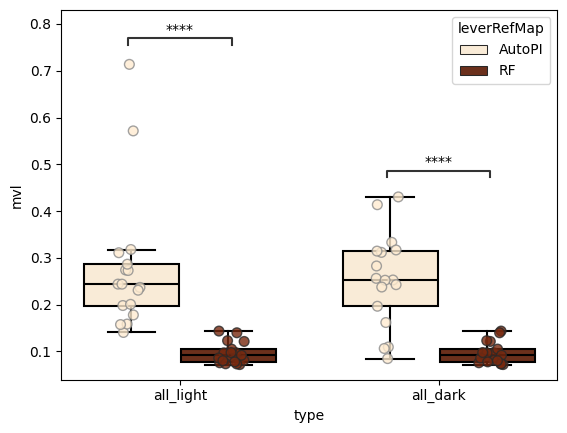

In [41]:
fig, ax =plt.subplots()
boxPlotColors = ['#ffecd1','#ff7d00','#15616d','#78290f']
y = 'mvl'

four_custom = [boxPlotColors[0],boxPlotColors[3]] #'#5800ff'
custom_pallet = sns.color_palette(four_custom)

b = sns.boxplot(x="type", y=y, hue="leverRefMap", data=leverRefCombinedG, order = ["all_light",'all_dark'],dodge=True, showfliers = False,hue_order=['AutoPI','RF'],
                 palette = custom_pallet, **boxplot_kwargs)
sns.stripplot(x="type", y=y, hue="leverRefMap", data=leverRefCombinedG, order = ["all_light",'all_dark'],hue_order=['AutoPI','RF'],
                palette = custom_pallet, dodge = True, legend=False,**stripplot_kwargs) #, legend=False

pairs=[[("all_dark", "AutoPI"),("all_dark","RF")],[("all_light", "AutoPI"),("all_light","RF")]]

annotator = Annotator(b, pairs, data=leverRefCombinedG,x='type',y='mvl', hue="leverRefMap",hue_order=['AutoPI','RF'],order = ["all_light",'all_dark'])
annotator.configure(test='Wilcoxon', text_format='star', loc='inside') #Wilcoxon, Mann-Whitney
annotator.apply_and_annotate()

In [42]:
def boxplot_from_lever_ref_in_rf_and_task(ax,inputDf,y,ylabel):
    four_custom = [boxPlotColors[0],boxPlotColors[3]] #'#5800ff'
    custom_pallet = sns.color_palette(four_custom)
    
    
    b = sns.boxplot(x="type", y=y, hue="leverRefMap", data=inputDf, order = ["all_light",'all_dark'],dodge=True, showfliers = False,hue_order=['AutoPI','RF'],
                    palette = custom_pallet, **boxplot_kwargs)
    sns.stripplot(x="type", y=y, hue="leverRefMap", data=inputDf, order = ["all_light",'all_dark'],hue_order=['AutoPI','RF'],
                    palette = custom_pallet, dodge = True, legend=False,**stripplot_kwargs) #, legend=False

    

    
    
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
    ax.set_xlabel("")
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0,0.6)
    
    sns.move_legend(b, 'lower center',
                bbox_to_anchor = (.73,0.81),
                ncol=1,
                title=None,
                frameon=False,
                fontsize = GLOBALFONTSIZE)
    
    pairs=[[("all_dark", "AutoPI"),("all_dark","RF")],[("all_light", "AutoPI"),("all_light","RF")]]


    annotator = Annotator(b, pairs, data=inputDf,x='type',y='mvl', hue="leverRefMap",hue_order=['AutoPI','RF'],order = ["all_light",'all_dark'])
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside') #Wilcoxon, Mann-Whitney
    annotator.apply_and_annotate()
    
    ax.set_xticklabels(["Light","Dark"],rotation= 0,ha = "center",fontsize=GLOBALFONTSIZE)
    
    number = len(inputDf.mouse.unique())
    ax.text(0.07,0.95, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)
    ax.set_ylim(0,1)


# Load anchoring strength

In [43]:
fn = myProject.dataPath+"/results/dfBridgeVonMises.csv"

print("Loading",fn)
dfBridgeVonMises = pd.read_csv(fn)

Loading /adata/projects/autopi_mec/results/dfBridgeVonMises.csv


In [44]:
fn = myProject.dataPath+"/results/dfLeverVonMises.csv"

print("Loading",fn)
dfLeverVonMises = pd.read_csv(fn)

Loading /adata/projects/autopi_mec/results/dfLeverVonMises.csv


In [45]:
dfBridgeVonMises = dfBridgeVonMises.drop("level_3",axis=1)
dfLeverVonMises = dfLeverVonMises.drop("level_3",axis=1)

In [46]:
dfBridgeVonMises

condition               session  trialBin        k0  \
0               atLever_dark  jp1084-05042022-0107         0  0.450502   
1               atLever_dark  jp1084-05042022-0107         1  0.313752   
2               atLever_dark  jp1084-05042022-0107         2  0.000100   
3               atLever_dark  jp1084-07042022-0107         0  0.457286   
4               atLever_dark  jp1084-07042022-0107         1  0.283785   
..                       ...                   ...       ...       ...   
877  searchToLeverPath_light  mn8578-25122021-0107         1  1.946292   
878  searchToLeverPath_light  mn8578-25122021-0107         2  1.736044   
879  searchToLeverPath_light  mn8599-11022022-0107         0  0.465958   
880  searchToLeverPath_light  mn8599-11022022-0107         1  0.420235   
881  searchToLeverPath_light  mn8599-11022022-0107         2  0.514216   

           k1         k       mu0       mu1  
0    0.394618  0.422560 -0.217871 -0.217871  
1    0.000100  0.156926  0.190724  0.190724  
2    0.000100  0.000100 -2.079140 -2.079140  
3    0.618668  0.537977  0.452487  0.452487  
4    0.315691  0.299738  0.170932  0.170932  
..        ...       ...       ...       ...  
877  0.990439  1.468366  2.231556  2.231556  
878  0.484608  1.110326  2.034164  2.034164  
879  1.469113  0.967535  2.689967  2.689967  
880  0.578794  0.499514  0.807549  0.807549  
881  0.414446  0.464331  0.345343  0.345343  

[882 rows x 8 columns]

In [47]:
shortConditionNames = {'searchToLeverPath_light': "Search",'searchToLeverPath_dark':"Search",
            'atLever_light':"Lever",'atLever_dark':"Lever", 
            'homingFromLeavingLeverToPeriphery_light':"Homing",
            'homingFromLeavingLeverToPeriphery_dark':"Homing"}

lightNames = {'searchToLeverPath_light': "Light",
            'searchToLeverPath_dark':"Dark",
            'atLever_light':"Light",
            'atLever_dark':"Dark", 
            'homingFromLeavingLeverToPeriphery_light':"Light",
            'homingFromLeavingLeverToPeriphery_dark':"Dark"}

trialBinNames ={0:"Beg.",
          1: "Middle",
          2: "End"}


for df in [dfBridgeVonMises, dfLeverVonMises]:
    df["shortCondition"] = [shortConditionNames[c] for c in df.condition]
    df["light"] = [lightNames[c] for c in df.condition]
    df["trialBinName"] = [trialBinNames[c] for c in df.trialBin]

In [48]:
dfBridgeVonMises["k"] = (dfBridgeVonMises.k0+dfBridgeVonMises.k1)/2
dfBridgeVonMises

condition               session  trialBin        k0  \
0               atLever_dark  jp1084-05042022-0107         0  0.450502   
1               atLever_dark  jp1084-05042022-0107         1  0.313752   
2               atLever_dark  jp1084-05042022-0107         2  0.000100   
3               atLever_dark  jp1084-07042022-0107         0  0.457286   
4               atLever_dark  jp1084-07042022-0107         1  0.283785   
..                       ...                   ...       ...       ...   
877  searchToLeverPath_light  mn8578-25122021-0107         1  1.946292   
878  searchToLeverPath_light  mn8578-25122021-0107         2  1.736044   
879  searchToLeverPath_light  mn8599-11022022-0107         0  0.465958   
880  searchToLeverPath_light  mn8599-11022022-0107         1  0.420235   
881  searchToLeverPath_light  mn8599-11022022-0107         2  0.514216   

           k1         k       mu0       mu1 shortCondition  light trialBinName  
0    0.394618  0.422560 -0.217871 -0.217871          Lever   Dark         Beg.  
1    0.000100  0.156926  0.190724  0.190724          Lever   Dark       Middle  
2    0.000100  0.000100 -2.079140 -2.079140          Lever   Dark          End  
3    0.618668  0.537977  0.452487  0.452487          Lever   Dark         Beg.  
4    0.315691  0.299738  0.170932  0.170932          Lever   Dark       Middle  
..        ...       ...       ...       ...            ...    ...          ...  
877  0.990439  1.468366  2.231556  2.231556         Search  Light       Middle  
878  0.484608  1.110326  2.034164  2.034164         Search  Light          End  
879  1.469113  0.967535  2.689967  2.689967         Search  Light         Beg.  
880  0.578794  0.499514  0.807549  0.807549         Search  Light       Middle  
881  0.414446  0.464331  0.345343  0.345343         Search  Light          End  

[882 rows x 11 columns]

In [49]:
dfLeverVonMises["anchor"] = "Lever"
dfBridgeVonMises["anchor"] = "Bridge"
dfAnchor = pd.concat([dfLeverVonMises,dfBridgeVonMises])
dfAnchor

condition               session  trialBin        k0  \
0               atLever_dark  jp1084-05042022-0107         0  0.000100   
1               atLever_dark  jp1084-05042022-0107         1  0.875837   
2               atLever_dark  jp1084-05042022-0107         2  1.109553   
3               atLever_dark  jp1084-07042022-0107         0  0.502837   
4               atLever_dark  jp1084-07042022-0107         1  0.890203   
..                       ...                   ...       ...       ...   
877  searchToLeverPath_light  mn8578-25122021-0107         1  1.946292   
878  searchToLeverPath_light  mn8578-25122021-0107         2  1.736044   
879  searchToLeverPath_light  mn8599-11022022-0107         0  0.465958   
880  searchToLeverPath_light  mn8599-11022022-0107         1  0.420235   
881  searchToLeverPath_light  mn8599-11022022-0107         2  0.514216   

           k1         k       mu0       mu1 shortCondition  light  \
0    0.386615  0.193357  0.499890  0.499890          Lever   Dark   
1    1.132931  1.004384 -1.234367 -1.234367          Lever   Dark   
2    1.141339  1.125446 -1.011247 -1.011247          Lever   Dark   
3    0.700210  0.601524 -1.761129 -1.761129          Lever   Dark   
4    0.243074  0.566639 -1.383773 -1.383773          Lever   Dark   
..        ...       ...       ...       ...            ...    ...   
877  0.990439  1.468366  2.231556  2.231556         Search  Light   
878  0.484608  1.110326  2.034164  2.034164         Search  Light   
879  1.469113  0.967535  2.689967  2.689967         Search  Light   
880  0.578794  0.499514  0.807549  0.807549         Search  Light   
881  0.414446  0.464331  0.345343  0.345343         Search  Light   

    trialBinName  anchor  
0           Beg.   Lever  
1         Middle   Lever  
2            End   Lever  
3           Beg.   Lever  
4         Middle   Lever  
..           ...     ...  
877       Middle  Bridge  
878          End  Bridge  
879         Beg.  Bridge  
880       Middle  Bridge  
881          End  Bridge  

[1764 rows x 12 columns]

In [50]:
dfAnchor = dfAnchor[dfAnchor.session.isin(useAble)]

# Final

In [51]:
def plotmap(axes, cluId, maps,showYLabel=True):
    mapindex=gc[gc.cluId==cluId].cluId
    #print(mapindex,mapindex.index)
    im=maps['circ80_2'][mapindex.index][0]
    im=im[:,~np.isnan(im).all(axis=0)]
    im=im[~np.isnan(im).all(axis=1),:]
    axes.imshow(im.T,origin="lower",cmap='viridis',interpolation=None)
    axes.set_title(f'{np.round(np.nanmax(im),2)} Hz',pad=3,y=0.99)
    #axes.axis('off')
    #if showYLabel:
    #    axes.set_ylabel("Random\nforaging",fontsize= GLOBALFONTSIZE)
    axes.set_xlabel('')
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])
    
    

In [52]:
def plotLeverMap(axes, cluId, maps,condition='all_light',r='none',showYLabel=True):
    #mapindex=gc[gc.cluId==cluId].cluId
    #print(mapindex,mapindex.index)
    nCells=maps["map"]["all_light"]["none"]['data'].shape[0]
    
    for i in range(nCells):
        if maps["map"][condition][r]['cluid'][i] == cluId:
            mapToPlot = maps["map"][condition][r]['data'][i]
            break
        
    
    im = mapToPlot
    #im=maps['circ80_2'][mapindex.index][0]
    im=im[:,~np.isnan(im).all(axis=0)]
    im=im[~np.isnan(im).all(axis=1),:]
    axes.imshow(im.T,origin="lower",cmap='viridis',interpolation=None)
    axes.set_title(f'{np.round(np.nanmax(im),2)} Hz')
    #axes.axis('off')
    #if showYLabel:
    #    axes.set_ylabel("Random\nforaging",fontsize= GLOBALFONTSIZE)
    axes.set_xlabel('')
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])
    

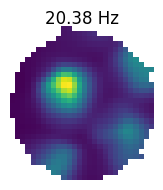

In [53]:
fig, ax = plt.subplots(figsize=(2,2))
cluid = 'jp486-26032023-0108_751'
plotmap(ax,cluid,myMaps)

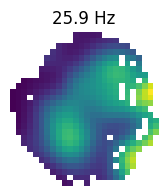

In [54]:
fig, ax = plt.subplots(figsize=(2,2))
cluid = "jp3129-04062022-0108_389"
plotLeverMap(ax,cluid,myLeverMaps,condition='all_light',r='arenaref') #none, arenaref

In [55]:
def plotLeverMaps(gs, cellDict, interval='all'):
    exampleNumber = 3
    
    gss0 = gridspec.GridSpecFromSubplotSpec(16,6,subplot_spec= gs[:,:])
    
    for j,light in enumerate(["light","dark"]):
        for i,c in enumerate(cellDict[light]["cellIds"]):
            cluId = cellDict[light]["cellIds"][i]
            trialList=cellDict[light]["trialLists"][i]
            mapindex=gc[gc.cluId==cluId].cluId
            mapindex=mapindex.index[0]
            
            if light == 'light':
                borderCo = '#fc8d03'
            else:
                borderCo = '#5950e9'
                
            if i == 0:
                showY=True
            else:
                showY=False
            
            if j != 0:
                showY=False
                
            if j == 0:
                a = i
            else:
                a = i+3
            
            cellName = cluId.split('-')[0]+cluId.split('-')[1]+cluId.split('_')[1]
            
            axes = fig.add_subplot(gss0[1:5, a])
            plotmap(axes,cluId,myMaps,showYLabel=showY)
            if showY:
                axes.set_ylabel("Random\nforaging",fontsize= GLOBALFONTSIZE)
            
            axes = fig.add_subplot(gss0[5:9, a])
            spikeOnPathSingleTrial(axes,cluId,trialList, light,borderColor=borderCo)
            #axes.set_title(cellName)
            #axes.set_title(f'Cell {i+1}')
            
            axes = fig.add_subplot(gss0[9:11, a])
            
            plotAngularMap(axes,leverIFR[cluId]['histo'][f'{interval}_{light}_animalAngleFromLever'],bc=borderCo,showYLabel=showY)
            
            axes = fig.add_subplot(gss0[11:15, a])
                
            plotLeverIFRMatrix(axes,cellId=cluId,light=f'{interval}_{light}',showXLabel=True,sort=True,showYLabel = showY)


In [56]:


def plot_anchoring_strength_box(ax,inputDf,ylabel='',title='',legend=True,ylim=3,legendX=0.7,legendY=0.6,titleName='',pal=None):
    if not pal:
        pal = {
        'Lever':boxPlotColors[0],
        'Room':boxPlotColors[1]
        }
        
    inputDf.replace({'Bridge':'Room'},inplace=True)
    
    b = sns.boxplot(data=inputDf, x= "trialBinName", hue = "anchor",palette = pal,y="k",showfliers=False,**boxplot_kwargs)
    sns.stripplot(data=inputDf, x= "trialBinName", hue = "anchor",y="k",palette = pal, dodge = True, legend=False,**stripplot_kwargs)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlabel('')
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE,labelpad=1)
    
    ax.set_title(titleName,fontsize=GLOBALFONTSIZE)
    
    if title=="Search":
        ax.set_ylim(0,4)
        ax.set_yticks([0,1,2,3,4])
        ax.set_yticklabels([0,1,2,3,4])
    elif title=='At lever':
        ax.set_ylim(0,3)
        ax.set_yticks([0,1,2,3])
        ax.set_yticklabels([0,1,2,3])
        
    ax.set_ylim(0,ylim)
    if legend:  
        sns.move_legend(b, 'lower center',
                    bbox_to_anchor = (legendX,legendY),
                    ncol=1,
                    title=None,
                    frameon=False,
                    fontsize = GLOBALFONTSIZE)
        
    else:
        ax.legend().set_visible(False)
    
    pairs=[[("Beg.","Lever"),("Beg.","Room")],[("Middle","Lever"),("Middle","Room")],[("End","Lever"),("End","Room")]]

    annotator = Annotator(b, pairs, x="trialBinName", y='k', hue="anchor", data=inputDf)
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside') #Wilcoxon, Mann-Whitney
    annotator.apply_and_annotate()
    
    number = len(inputDf.session.unique())
    
    ax.text(0.07,0.96, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)
    
    
        
    

In [57]:
shuffleHolder = []
sesHolder = []
light_condition = 'atLever_light'
for s in shuffleData.keys():
    sd = shuffleData[s][light_condition]['shuffled']
    shuffleHolder.append(sd)
    sesHolder.append(s)
        
    
shuffleLightDf = pd.DataFrame(np.array(shuffleHolder).T,columns=sesHolder)
longDf = shuffleLightDf.melt(var_name = 'Session', value_name = 'Values')
longDf['Session'] = longDf['Session'].apply(lambda x: x.split('-')[0] + '-' + x.split('-')[1])
                                                
percentile_95 = np.percentile(longDf['Values'],95)

In [58]:
valueHolder = []                                      
for s in shuffleData.keys():
    ak = shuffleData[s][light_condition]['predicted']
    valueHolder.append(ak)

In [59]:
def create_color_mapping(session_list, color='#d9d9d9'):
    color_mapping = {session: color for session in session_list}
    return color_mapping

def get_shuffle_map(ax, condition = 'atLever_dark',title='',legend=False,customLegend=True,xlim=2.7,ylabel=''):
    shuffleHolder = []
    sesHolder = []
    light_condition = condition
    for s in shuffleData.keys():
        sd = shuffleData[s][light_condition]['shuffled']
        shuffleHolder.append(sd)
        sesHolder.append(s)
        
    color_mapping = create_color_mapping(sesHolder)

    color_palette = sns.color_palette([color_mapping[s] for s in shuffleData.keys()])

    shuffleLightDf = pd.DataFrame(np.array(shuffleHolder).T,columns=sesHolder)
    longDf = shuffleLightDf.melt(var_name = 'Session', value_name = 'Values')
    longDf['Session'] = longDf['Session'].apply(lambda x: x.split('-')[0] + '-' + x.split('-')[1])

    b = sns.histplot(data=longDf,x='Values', hue='Session',multiple='stack',palette = color_palette,alpha=1,legend=legend)

    percentile_95 = np.percentile(longDf['Values'],95)

  
    for s in shuffleData.keys():
        ak = shuffleData[s][light_condition]['predicted']
        c = '#00afb9'
        ax.axvline(x=ak, ymax=0.8, color=c, linestyle='-',lw=1.5)
        
    ak_list = [shuffleData[s][light_condition]['predicted'] for s in shuffleData.keys()]
    # Count how many 'ak' values are above the 95th percentile
    count_above = sum(1 for ak in ak_list if ak > percentile_95)
    total = len(ak_list)

    print(f"{count_above} out of {total} are above the 95th percentile for {condition}")
        
    ax.axvline(x = percentile_95, color = '#f07167', linestyle='--',lw=2)

    #ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.set_aspect('equal')
    
    ax.set_xlabel('Anchoring strength',fontsize=GLOBALFONTSIZE)
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE,labelpad=1)
    ax.set_title(title,fontsize=GLOBALFONTSIZE)
    
    ax.set_xlim(0,xlim)
    ax.set_ylim(0,1000)
    ax.set_yticks([0,1000])
    ax.set_yticklabels(['0','1k'])
    
    
    if legend:
        pass
        
    if customLegend:
        legend_labels = ['Shuffled','95% Perc.','Observed']
        legend_colors = ['#d9d9d9','#f07167','#00afb9']
        
        custom_legend = [plt.Line2D([],[],color=color, linestyle = '-') for color in legend_colors]
        
        ax.legend(custom_legend,legend_labels,fontsize= GLOBALFONTSIZE-2, frameon=False,loc='lower center', bbox_to_anchor = (0.8,0.5))
        
    
        

In [60]:
df_HDInfo[(df_HDInfo.light == 'all_light')&(df_HDInfo.shuffle)]

Info_score  HD_score  HD_peakrate                    cluid  Info_pc  \
0        0.277014  0.018806    37.317170  mn8578-30112021-0107_20      NaN   
1        1.008080  0.051572    18.293439  mn8578-30112021-0107_22      NaN   
2        7.696547  0.998844     0.194017  mn8578-30112021-0107_45      NaN   
3        5.075180  0.381281     1.606702  mn8578-30112021-0107_48      NaN   
4        2.346731  0.096101     4.229555  mn8578-30112021-0107_57      NaN   
...           ...       ...          ...                      ...      ...   
10845    1.799001  0.064134     4.643397  jp499-25052023-0108_523      NaN   
10846    0.566661  0.023311    17.860883  jp499-25052023-0108_528      NaN   
10847    0.498496  0.031475    26.515002  jp499-25052023-0108_530      NaN   
10848    0.885490  0.036298    12.064093  jp499-25052023-0108_533      NaN   
10849    4.808307  0.207500     0.810992  jp499-25052023-0108_535      NaN   

       HD_pc  peak_pc      light  shuffle           sessionName   mouse  
0        NaN      NaN  all_light     True  mn8578-30112021-0107  mn8578  
1        NaN      NaN  all_light     True  mn8578-30112021-0107  mn8578  
2        NaN      NaN  all_light     True  mn8578-30112021-0107  mn8578  
3        NaN      NaN  all_light     True  mn8578-30112021-0107  mn8578  
4        NaN      NaN  all_light     True  mn8578-30112021-0107  mn8578  
...      ...      ...        ...      ...                   ...     ...  
10845    NaN      NaN  all_light     True   jp499-25052023-0108   jp499  
10846    NaN      NaN  all_light     True   jp499-25052023-0108   jp499  
10847    NaN      NaN  all_light     True   jp499-25052023-0108   jp499  
10848    NaN      NaN  all_light     True   jp499-25052023-0108   jp499  
10849    NaN      NaN  all_light     True   jp499-25052023-0108   jp499  

[10850 rows x 11 columns]

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def plot_color_ring(ax): #Need to add this to the axis: subplot_kw={'projection': 'polar'}
    # Define your colors and create a custom colormap
    colors = ['#ff0080', '#3f5efb', '#40e0d0', '#ff8c00', '#ff0080']
    cmap = LinearSegmentedColormap.from_list('custom', colors)

    # Specify angles and radii for the circle ring
    angles = np.linspace(0, 2 * np.pi, 360) # Divide the circle into 360 degrees
    radii = np.ones(360)*2 # Set radii to 1 for a ring

    # Plot the circle ring with the specified colors based on angles
    ax.scatter(angles, radii, c=angles, cmap=cmap, s=50)

    # # Set the direction of the polar plot to clockwise
    ax.set_theta_direction(1) # Clockwise direction
    ax.set_theta_offset(np.pi) # Set 0 degrees to the top

    # # Remove the axis labels and grid
    ax.set_xticks([]) # Remove angle labels
    ax.set_yticks([]) # Remove radius labels

    ax.set_ylim(0, 2)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)

    # Set the aspect ratio to equal for a circular plot
    ax.set_aspect('equal')
    
    ax.set_title('Angle\nto lever',fontsize=GLOBALFONTSIZE-1)

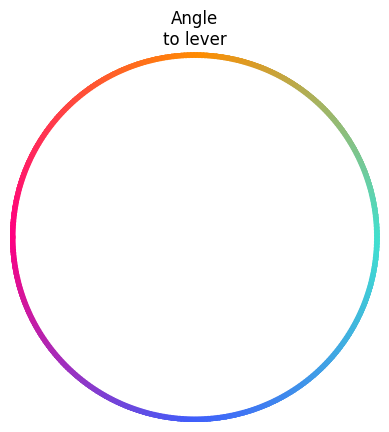

In [62]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plot_color_ring(ax)

In [63]:
len(myMaps['circ80_1'])

10850

In [64]:
leverGc['cluId']

27        mn8578-05122021-0108_61
32       mn8578-05122021-0108_161
36       mn8578-05122021-0108_197
39       mn8578-05122021-0108_233
42       mn8578-05122021-0108_238
                   ...           
10679     jp499-24052023-0108_438
10791     jp499-18052023-0108_743
10795     jp499-18052023-0108_761
10823     jp499-25052023-0108_382
10826     jp499-25052023-0108_398
Name: cluId, Length: 931, dtype: object

In [65]:
error_name = 'r'    
def mySummary(df):        
    error = np.nanmedian(df[f"{error_name}"])        
    return pd.DataFrame({"r": [error]})

leverMapCorPerMouse = leverMapCor[leverMapCor['cell1'].isin(leverGc['cluId'])].groupby(['mouse','rotation','condition']).apply(mySummary).reset_index()

In [66]:
error_name = 'HD_score'    
def mySummary(df):        
    error = np.nanmedian(df[f"{error_name}"])        
    return pd.DataFrame({"HD_score": [error]})

df_HDInfoPerMouse = df_HDInfo[df_HDInfo['cluid'].isin(leverGc['cluId'])].groupby(['mouse','light','shuffle']).apply(mySummary).reset_index()

# Same figure V2

In [67]:
def plotLeverMaps(gs, cellDict, interval='all'):
    exampleNumber = 3
    
    gss0 = gridspec.GridSpecFromSubplotSpec(16,6,subplot_spec= gs[:,:])
    
    for j,light in enumerate(["light","dark"]):
        for i,c in enumerate(cellDict[light]["cellIds"]):
            cluId = cellDict[light]["cellIds"][i]
            trialList=cellDict[light]["trialLists"][i]
            mapindex=gc[gc.cluId==cluId].cluId
            mapindex=mapindex.index[0]
            
            if light == 'light':
                borderCo = '#fc8d03'
            else:
                borderCo = '#5950e9'
                
            if i == 0:
                showY=True
            else:
                showY=False
            
            if j != 0:
                showY=False
                
            if j == 0:
                a = i
            else:
                a = i+3
            
            cellName = cluId.split('-')[0]+cluId.split('-')[1]+cluId.split('_')[1]
            
            axes = fig.add_subplot(gss0[1:5, a])
            plotmap(axes,cluId,myMaps,showYLabel=showY)
            
            if showY:
                axes.set_ylabel("Random\nforaging",fontsize= GLOBALFONTSIZE)
            
            axes = fig.add_subplot(gss0[5:9, a]) #1:5,5:7,7:11,11:15
            spikeOnPathSingleTrial(axes,cluId,trialList, light,borderColor=borderCo)
            
            axes = fig.add_subplot(gss0[9:11, a])
            plotAngularMap(axes,leverIFR[cluId]['histo'][f'{interval}_{light}_animalAngleFromLever'],bc='#4a4e69',showYLabel=showY) #bc=borderCo
            #axes.set_title(cellName)
            #axes.set_title(f'Cell {i+1}')
            
            axes = fig.add_subplot(gss0[11:15, a])
            plotLeverIFRMatrix(axes,cellId=cluId,light=f'{interval}_{light}',showXLabel=True,sort=True,showYLabel = showY)

In [68]:
fn = myProject.dataPath+"/results/reconstruction_shuffling.csv"
print('Loading', fn)

shuffleMvtError = pd.read_csv(fn,index_col=0)

Loading /adata/projects/autopi_mec/results/reconstruction_shuffling.csv


In [69]:
def plot_shuffle_distribution(ax0,shuffleDf):
    sns.kdeplot(data=shuffleDf,
                x='mvtDirError',color='gray',fill=None,lw=2,ax=ax0,alpha=0.5)


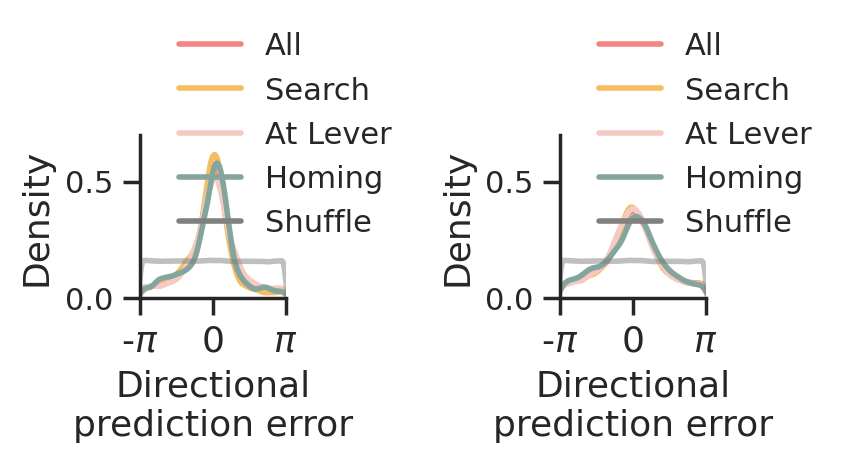

In [70]:
histoDf = allSessionDf[allSessionDf.session.isin(useAble)].copy() #[allSessionDf.session == s]
#Remove NANs
histoDf = histoDf.dropna(subset = ['xPose']).copy()
#Adjust for speed?
minSpeed = 10
histoDf = histoDf[(histoDf.speed > minSpeed) ].copy()

histoDf['light'] = histoDf['condition'].apply(lambda x: x.split('_')[1])
histoDf['cond_noLight'] = histoDf['condition'].apply(lambda x: x.split('_')[0])

def plot_histogram_per_condition(ax,plotDf,light='light',colorList=['#F6BD60','#F5CAC3','#84A59D','#F28482','gray'],legend=True,noYaxis = True,legendX = 1,legendY=0.2,ylim=0.7,xlabel='Directional\nprediction error',lw=2,title='',ylabel='Density'):
    sns.kdeplot(data=plotDf[(plotDf.cond_noLight == 'all')&(plotDf.light == light)],x='mvtDirError',color=colorList[0],fill=None,lw=lw)
    sns.kdeplot(data=plotDf[(plotDf.cond_noLight == 'searchToLeverPath')&(plotDf.light == light)],x='mvtDirError',color=colorList[1],fill=None,lw=lw)
    sns.kdeplot(data=plotDf[(plotDf.cond_noLight == 'atLever')&(plotDf.light == light)],x='mvtDirError',color=colorList[2],fill=None,lw=lw)
    sns.kdeplot(data=plotDf[(plotDf.cond_noLight == 'homingFromLeavingLeverToPeriphery')&(plotDf.light == light)],x='mvtDirError',color=colorList[3],fill=None,lw=lw)
    
    ax.set_title(title,fontsize=GLOBALFONTSIZE)

    light_median = plotDf[(plotDf.cond_noLight == 'searchToLeverPath')&(plotDf.light == light)]['mvtDirError'].median()
    dark_median = plotDf[(plotDf.cond_noLight == 'atLever')&(plotDf.light == light)]['mvtDirError'].median()
    
    ax.set_ylim(0,ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(xlabel, fontsize=GLOBALFONTSIZE)
    ax.set_ylabel(ylabel, fontsize=GLOBALFONTSIZE)
    ax.set_xticks(ticks=[-np.pi, 0, np.pi])
    ax.set_xticklabels(["-$\pi$","0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    ax.set_xlim(-np.pi,np.pi)


    if legend:
        legend_labels = ['All','Search','At Lever','Homing','Shuffle']
        legend_colors = colorList
        
        custom_legend = [plt.Line2D([],[],color=color, linestyle = '-',lw=lw) for color in legend_colors]
        
        ax.legend(custom_legend,legend_labels,fontsize= GLOBALFONTSIZE-2, frameon=False,loc='lower center', bbox_to_anchor = (legendX,legendY))
        
    if noYaxis:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.set_yticks([])


nrows = 1
ncols = 2
colSize = 2.1
rowSize = 2.1
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})

#Data Used For Making the Plot
sns.set_theme(style = 'ticks')

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
gs = GridSpec(nrows,ncols,figure = fig)

ax = fig.add_subplot(gs[0,0])
plot_histogram_per_condition(ax,histoDf,'light',colorList=['#F28482','#F6BD60','#F5CAC3','#84A59D','gray'],noYaxis=False)
plot_shuffle_distribution(ax,shuffleMvtError)

    
ax = fig.add_subplot(gs[0,1])
plot_histogram_per_condition(ax,histoDf,'dark',colorList=['#F28482','#F6BD60','#F5CAC3','#84A59D','gray'],noYaxis=False)
plot_shuffle_distribution(ax,shuffleMvtError)

In [71]:
# These two functions below give us the ability to move the ring to the center

In [72]:
def plot_lever_full_gridCoord(ax,df,c ='atLever_dark',predicted = True,double=False,stack= False,x_shift=0, y_shift=0,
                              simple=False, ylabel = '',customTicks=True,title='',omitYticks=False,omitXTicks=False):
    trialDf = df[df.condition == c].copy()
    if double:
        v0,v1 = get_double_lever_v(trialDf,predicted=predicted)
        
        vCoordinates_l = pd.DataFrame(np.array([v0,v1,list(trialDf[color_map_hue])*4]).T,columns = ['v0_l','v1_l',color_map_hue])
    else:
        v0,v1 = get_lever_v(trialDf,predicted=predicted)
        vCoordinates_l = pd.DataFrame(np.array([v0,v1,trialDf[color_map_hue]]).T,columns = ['v0_l','v1_l',color_map_hue])
    if double:
        v0,v1 = get_double_v(trialDf,predicted=predicted)
        vCoordinates = pd.DataFrame(np.array([v0,v1,list(trialDf[color_map_hue])*4]).T,columns = ['v0','v1',color_map_hue])
    else:
        v0,v1 = get_v(trialDf,predicted=predicted)
        vCoordinates = pd.DataFrame(np.array([v0,v1,trialDf[color_map_hue]]).T,columns = ['v0','v1',color_map_hue])
    colorMap = cmap

    x_max = 2 * np.pi + x_shift
    y_max = 2 * np.pi + y_shift
    mask = (vCoordinates.v0 < x_max) & (vCoordinates.v0 >= x_shift) & (vCoordinates.v1 < y_max) & (vCoordinates.v1 >= y_shift)

    # Second mask with a margin of np.pi/2 on each side of the x and y axes
    margin = 0
    x_margin_mask = (vCoordinates.v0 < x_max + margin) & (vCoordinates.v0 >= x_shift - margin)
    y_margin_mask = (vCoordinates.v1 < y_max + margin) & (vCoordinates.v1 >= y_shift - margin)
    

    # Combine the two masks using logical OR (|) to include points in either mask
    combined_mask = mask | (x_margin_mask & y_margin_mask)
        
    a = sns.kdeplot(data=vCoordinates_l,x = 'v0_l',y = 'v1_l',alpha = 1, fill=True, ax = ax)
    if stack:
        a = sns.scatterplot(data=vCoordinates,x = 'v0',y = 'v1',hue = color_map_hue, palette = colorMap, ax = ax,legend=False,s = 1)

        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel("Grid Coordinate X",fontsize=GLOBALFONTSIZE)
    ax.set_ylabel("Grid Coordinate Y",fontsize=GLOBALFONTSIZE)
    ax.set_aspect('equal')
    if not double:
        ax.set_xticks(ticks=[-np.pi, 0, np.pi])
        ax.set_xticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, 0, np.pi])
        ax.set_yticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    else:
        ax.set_xticks(ticks=[-np.pi, 0, 3*np.pi])
        ax.set_xticklabels([r'-$\pi$', "0", "3$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, 0, 3*np.pi])
        ax.set_yticklabels([r'-$\pi$', "0", "3$\pi$"],fontsize=GLOBALFONTSIZE)
    if double:
        d = 'LOOPED'
    else:
        d = ''
    if predicted:
        ax.set_title(f'{d} Predicted Grid, {c}',fontsize=GLOBALFONTSIZE)
    else:
        ax.set_title(f'{d} Actual Grid, {c}',fontsize=GLOBALFONTSIZE)
        
    if simple:
        ax.set_xticks(ticks=[0, 2*np.pi])
        ax.set_xticklabels(["0", "2$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[0, 2*np.pi])
        ax.set_yticklabels(["0", "2$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_xlim(0,2*np.pi)
        ax.set_ylim(0,2*np.pi)
        ax.set_title(title,fontsize=GLOBALFONTSIZE)
        ax.set_xlabel("")
        ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
        
    if customTicks:
        x_ticks = [x_shift+margin,2*np.pi + x_shift+margin]
        y_ticks = [y_shift+margin,2*np.pi + y_shift+margin]
        
        ax.set_xticks(ticks=x_ticks)
        ax.set_yticks(ticks=y_ticks)
        
        if omitXTicks:
            ax.set_xticks([])
            ax.set_xticklabels([],fontsize=GLOBALFONTSIZE)
        else:
            ax.set_xticklabels(["0","2$\pi$"],fontsize=GLOBALFONTSIZE)
            
        if omitYticks:
            ax.set_yticks([])
            ax.set_yticklabels([],fontsize=GLOBALFONTSIZE)
        else:

            ax.set_yticklabels(["0","2$\pi$"],fontsize=GLOBALFONTSIZE)


    
        
        ax.set_xlim(x_shift+margin,2*np.pi + x_shift+margin)
        ax.set_ylim(y_shift+margin,2*np.pi + y_shift+margin)

In [73]:
def plot_example_full_gridCoord(ax,df,c ='atLever_dark',predicted = True,double=True,color_map_hue='leverAngle',simple=False, x_shift=0, y_shift=0, 
                                ylabel = '',customTicks=True,title='',omitYticks=False,omitXTicks=False):
    
    trialDf = df[df.condition == c].copy()
    
    if double:
        v0,v1 = get_double_v(trialDf,predicted=predicted)
        vCoordinates = pd.DataFrame(np.array([v0,v1,list(trialDf[color_map_hue])*4]).T,columns = ['v0','v1',color_map_hue])
    else:
        v0,v1 = get_v(trialDf,predicted=predicted)
        vCoordinates = pd.DataFrame(np.array([v0,v1,trialDf[color_map_hue]]).T,columns = ['v0','v1',color_map_hue])

    
    
    colorMap = cmap
    
    x_max = 2 * np.pi + x_shift
    y_max = 2 * np.pi + y_shift
    
    mask = (vCoordinates.v0 < x_max) & (vCoordinates.v0 >= x_shift) & (vCoordinates.v1 < y_max) & (vCoordinates.v1 >= y_shift)

    # Second mask with a margin of np.pi/2 on each side of the x and y axes
    margin = 0
    x_margin_mask = (vCoordinates.v0 < x_max + margin) & (vCoordinates.v0 >= x_shift - margin)
    y_margin_mask = (vCoordinates.v1 < y_max + margin) & (vCoordinates.v1 >= y_shift - margin)
    

    # Combine the two masks using logical OR (|) to include points in either mask
    combined_mask = mask | (x_margin_mask & y_margin_mask)
    
    a = sns.scatterplot(data=vCoordinates[mask],x = 'v0',y = 'v1',hue = color_map_hue, palette = colorMap,hue_norm=GLOBALHUENORM, ax = ax,legend=False,s = 2,alpha = 1)

    sns.scatterplot(data=vCoordinates[combined_mask],x = 'v0',y = 'v1',hue = color_map_hue, palette = colorMap,hue_norm=GLOBALHUENORM, ax = ax,legend=False,s = 2,alpha = 1)
    

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Grid Coordinate X")
    ax.set_ylabel("Grid Coordinate Y")
    
    ax.set_aspect('equal')
    if not double:
        ax.set_xticks(ticks=[-np.pi, 0, np.pi])
        ax.set_xticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, 0, np.pi])
        ax.set_yticklabels([r'-$\pi$', "0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    
    else:
        ax.set_xticks(ticks=[-np.pi, 0, 3*np.pi])
        ax.set_xticklabels([r'-$\pi$', "0", "3$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[-np.pi, 0, 3*np.pi])
        ax.set_yticklabels([r'-$\pi$', "0", "3$\pi$"],fontsize=GLOBALFONTSIZE)
        
    if double:
        d = 'LOOPED'
    else:
        d = ''
    
    if predicted:
        ax.set_title(f'{d} Predicted Grid, {c}',fontsize=GLOBALFONTSIZE)
    else: 
        ax.set_title(f'{d} Actual Grid, {c}',fontsize=GLOBALFONTSIZE)
        
    if simple:
        ax.set_xticks(ticks=[0, 2*np.pi])
        ax.set_xticklabels(["0", "2$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_yticks(ticks=[0, 2*np.pi])
        ax.set_yticklabels(["0", "2$\pi$"],fontsize=GLOBALFONTSIZE)
        ax.set_xlim(0,2*np.pi)
        ax.set_ylim(0,2*np.pi)
        
        # ax.spines['left'].set_visible(False)
        # ax.spines['bottom'].set_visible(False)
        
        ax.set_xlabel("")
        ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
        ax.set_title(title,fontsize=GLOBALFONTSIZE)
        
    if customTicks:
        x_ticks = [x_shift+margin,2*np.pi + x_shift+margin]
        y_ticks = [y_shift+margin,2*np.pi + y_shift+margin]
        
        ax.set_xticks(ticks=x_ticks)
        ax.set_yticks(ticks=y_ticks)
        
        if omitXTicks:
            ax.set_xticks([])
            ax.set_xticklabels([],fontsize=GLOBALFONTSIZE)
        else:
            ax.set_xticklabels(["0","2$\pi$"],fontsize=GLOBALFONTSIZE)
        
        if omitYticks:
            ax.set_yticks([])
            ax.set_yticklabels([],fontsize=GLOBALFONTSIZE)
        else:
            ax.set_yticklabels(["0","2$\pi$"],fontsize=GLOBALFONTSIZE)
        
        ax.set_xlim(x_shift+margin,2*np.pi + x_shift+margin)
        ax.set_ylim(y_shift+margin,2*np.pi + y_shift+margin)

In [74]:
def plotMap(ax,myMap,title="",titleY=0.2,titleFontSize=10,transpose=True,cmap="jet",vmin=0,alpha=1):
    """
    Plot one 2D map
    """
    if transpose:
        ax.imshow(myMap.T,origin="lower",cmap=cmap,interpolation=None, vmin=vmin,alpha=alpha)
    else:
        ax.imshow(myMap,origin="lower",cmap=cmap,interpolation=None, vmin=vmin,alpha=alpha)
    ax.set_title(title,y=titleY,fontsize=titleFontSize,pad=1)
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

In [75]:
import scipy
def custom_stripplot(ax, inputDf, light ='dark',var = 'mvtDirError',jitter=0.05, alpha=0.5, 
                     ms=8, mew=1, linewidth=0.5, linestyle='--', colors=['#F6BD60','#F5CAC3','#84A59D','#F28482'],ylim=0.8,ylabel='Directional\npred. error',Circular=False):

    splitVariable = ['searchToLeverPath','atLever']
    order = splitVariable
    

    processDf = inputDf[inputDf.light == light].copy()
    
    aggregatedMVL = pd.pivot_table(data=processDf,values = var,index='session',columns='cond_noLight').reset_index().copy()

    aggMvlNumpy = aggregatedMVL.loc[:,['searchToLeverPath','atLever']].values
        
        
    df = pd.DataFrame(aggMvlNumpy)

    df_x_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=df.values.shape), columns=df.columns)
    df_x_jitter += np.arange(len(df.columns))
    
    
    #Boxplot

    b = sns.boxplot(data=processDf,x = 'cond_noLight', y = var, ax=ax, palette=['white'],order = splitVariable,showfliers=False, **boxplot_kwargs)
    
    p = processDf['cond_noLight'].unique()
    
    pairs = [(p[0],p[1])]
    annotator = Annotator(b, pairs, data=processDf, 
                          x = 'cond_noLight', y = var,order=splitVariable)

    annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
    annotator.apply_and_annotate()
    
    for i, col in enumerate(df):
        if colors is not None:
            color = colors[i]
        else:
            color = 'C{}'.format(i)  # Use default Matplotlib color cycle

        ax.plot(df_x_jitter[col], df[col], 'o', alpha=alpha, zorder=1, ms=ms, mew=mew, color=color)

    ax.set_xticks(range(len(df.columns)))
    #ax.set_xticklabels(df.columns,fontsize=GLOBALFONTSIZE)
    ax.set_xlim(-0.5, len(df.columns) - 0.5)

    for idx in df.index:
        for i in range(0, len(df.columns), 2):
            ax.plot(df_x_jitter.loc[idx, [df.columns[i], df.columns[i + 1]]],
                    df.loc[idx, [df.columns[i], df.columns[i + 1]]],
                    color='grey', linewidth=linewidth, linestyle=linestyle, zorder=-1)
            
    
    
    ax.set_xticklabels(splitVariable,fontsize=GLOBALFONTSIZE)
    
    ax.set_ylim(-np.pi/2,np.pi/2)
    ax.set_yticks([-np.pi/2,0,np.pi/2])
    ax.set_yticklabels(["-$\pi$/2","0","$\pi$/2"])
    
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
    ax.set_title('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('')
    ax.set_xticklabels(['Search','At lever'])
    
    number = len(processDf.session.unique())
    
    res = scipy.stats.wilcoxon(processDf[processDf.cond_noLight == order[0]][var].values,processDf[processDf.cond_noLight == order[1]][var].values)
    
    ax.text(0.07,0.92, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)
    

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

searchToLeverPath vs. atLever: Wilcoxon test (paired samples), P_val:7.898e-01 Stat=1.400e+02


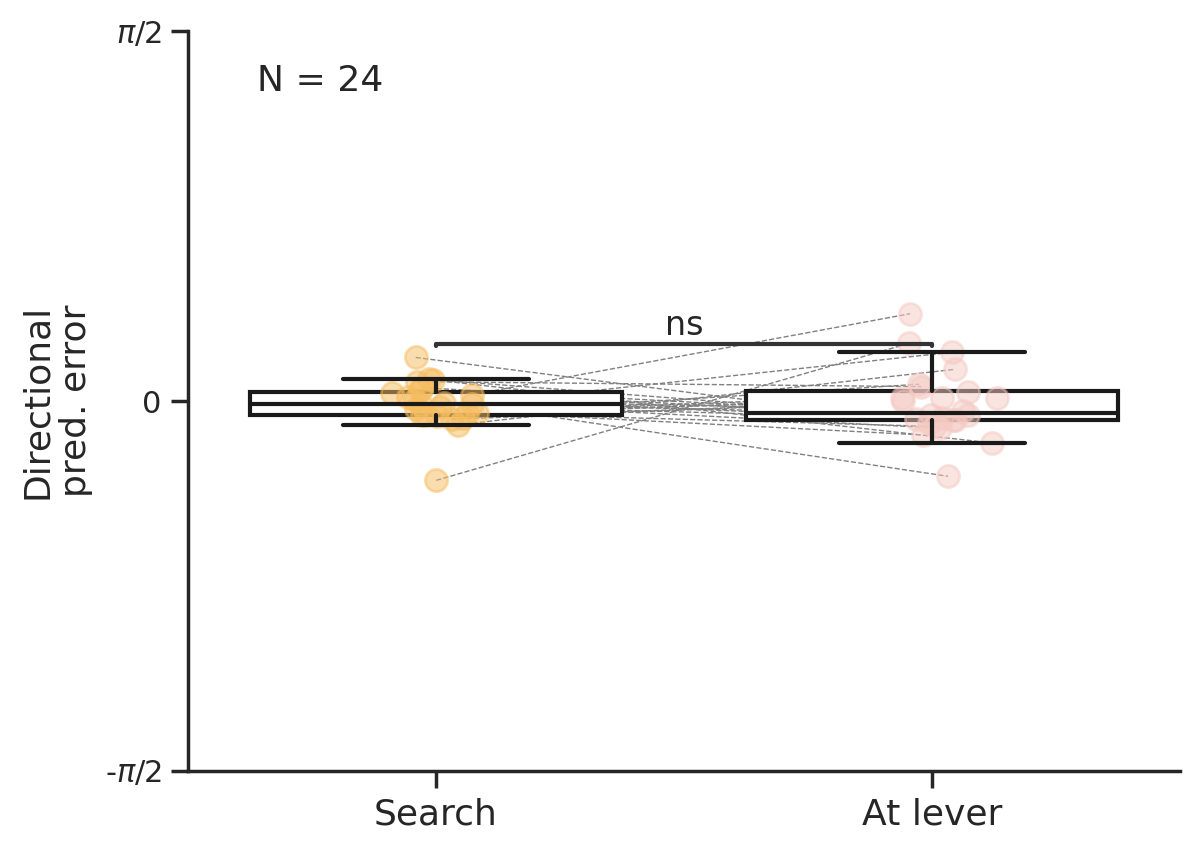

In [76]:
var = 'mvtDirError'
def mySummary(df):        
        error = np.nanmedian(df[f"{var}"])        
        return pd.DataFrame({f"{var}": [error]})
histoDfGrouped = histoDf.groupby(['session','cond_noLight','light']).apply(mySummary).reset_index()

condList = ['searchToLeverPath','atLever']
histoDfGroupedSearchLever = histoDfGrouped[histoDfGrouped.cond_noLight.isin(condList)]

fig, ax = plt.subplots()
custom_stripplot(ax,histoDfGroupedSearchLever,'dark')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

all_dark_AutoPI vs. all_dark_RF: Wilcoxon test (paired samples), P_val:7.629e-05 Stat=3.000e+00
all_light_AutoPI vs. all_light_RF: Wilcoxon test (paired samples), P_val:1.526e-05 Stat=0.000e+00


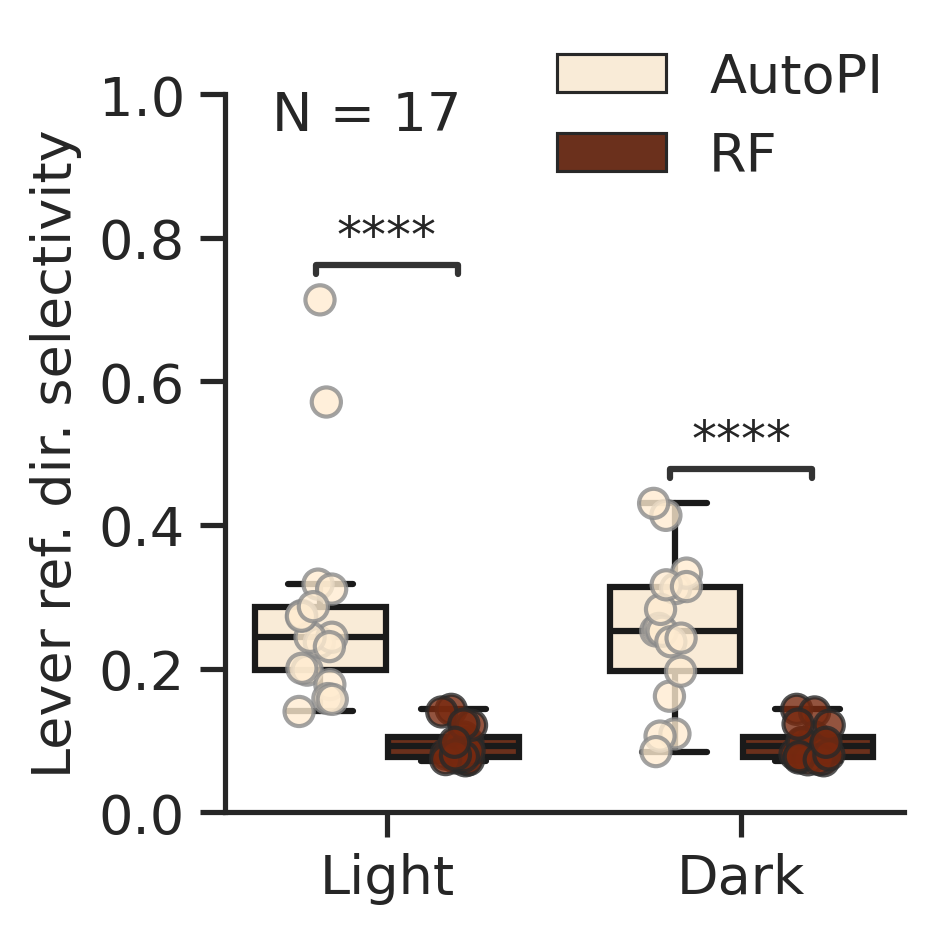

In [77]:
from matplotlib.image import imread

nrows = 1
ncols = 1
colSize = 3
rowSize = 3
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_theme(style = 'ticks')

def add_text(ax,x,y,label,fw = 'normal'):
    ax.text(x,y,label, style='normal', fontweight=fw, fontsize=GLOBALFONTSIZE+4,
                  verticalalignment='center', horizontalalignment='center', transform=ax.transAxes)
    
boxPlotColors = ['#ffecd1','#ff7d00','#15616d','#78290f'] #Lever First,

fig = plt.figure(figsize=(ncols*colSize,nrows*rowSize),constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig) #,width_ratios=[1]*6+[0.3]+[1] #height_ratios=[1]*4 + [0.2] + [1]*4


ax0 = fig.add_subplot(gs[0,0])
boxplot_from_lever_ref_in_rf_and_task(ax0,leverRefCombinedG,y='mvl',ylabel="Lever ref. dir. selectivity")

ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)

In [78]:
GLOBALFONTSIZE = 14

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

all_dark_AutoPI vs. all_dark_RF: Wilcoxon test (paired samples), P_val:7.629e-05 Stat=3.000e+00
all_light_AutoPI vs. all_light_RF: Wilcoxon test (paired samples), P_val:1.526e-05 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

d1d2_Lever ref. vs. d1d2_Room ref.: Wilcoxon test (paired samples), P_val:2.090e-03 Stat=1.500e+01
l1l2_Lever ref. vs. l1l2_Room ref.: Wilcoxon test (paired samples), P_val:6.777e-01 Stat=6.700e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

searchToLeverPath vs. atLever: W

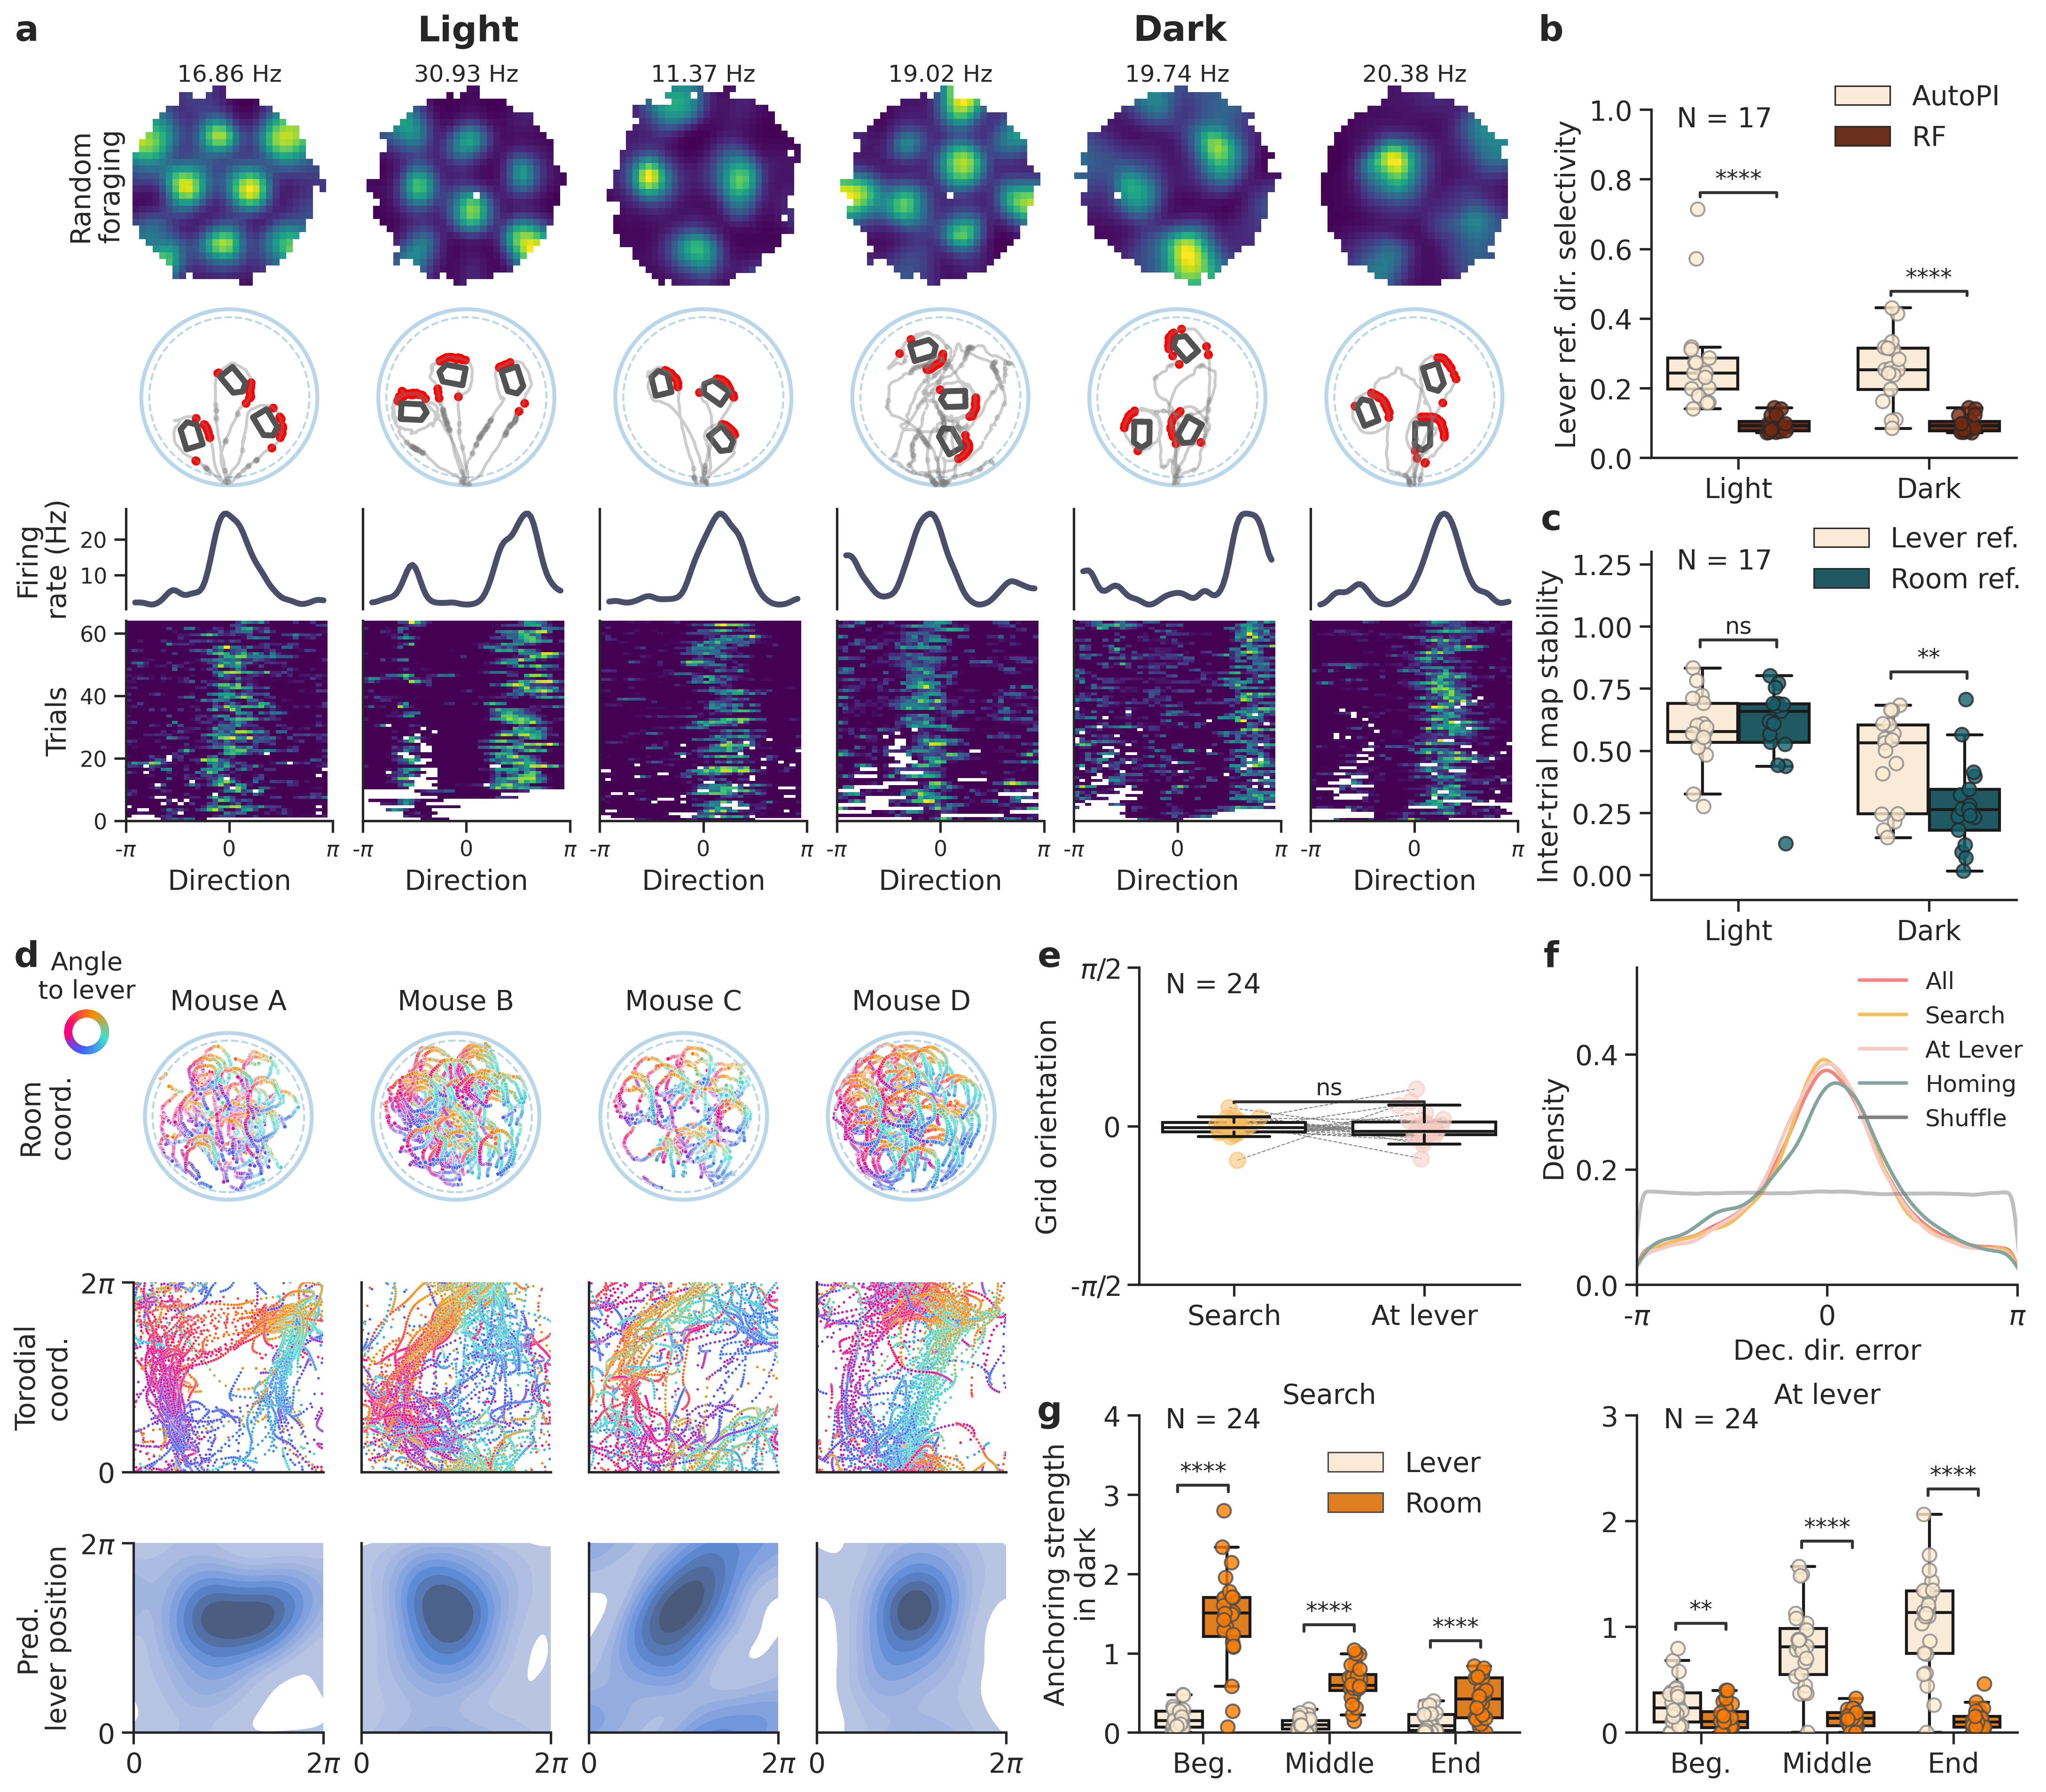

In [79]:
from matplotlib.image import imread
exampleNumber = 3

nrows = 7
ncols = 8
colSize = 1.8
rowSize = 1.8
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_theme(style = 'ticks')

def add_text(ax,x,y,label,fw = 'normal'):
    ax.text(x,y,label, style='normal', fontweight=fw, fontsize=GLOBALFONTSIZE+4,
                  verticalalignment='center', horizontalalignment='center', transform=ax.transAxes)
    
boxPlotColors = ['#ffecd1','#ff7d00','#15616d','#78290f'] #Lever First,
#Set the color for this figure

fig = plt.figure(figsize=(ncols*colSize,nrows*rowSize),constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig,height_ratios=[0.91]*4 +[1.09]*3) #,width_ratios=[1]*6+[0.3]+[1] #height_ratios=[1]*4 + [0.2] + [1]*4
gs0 = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec= gs[:4,:6])
gs1 = gridspec.GridSpecFromSubplotSpec(3,1,subplot_spec= gs[:4,6:],height_ratios=[0.17,1,1])
gs2 = gridspec.GridSpecFromSubplotSpec(4,4,subplot_spec= gs[4:,:4],height_ratios=[0.08] + [1]*3) #,height_ratios=[0.1] + [1]*3
gs3 = gridspec.GridSpecFromSubplotSpec(2,2,subplot_spec= gs[4:,4:])
gs4 = gridspec.GridSpecFromSubplotSpec(5,5,subplot_spec= gs[3:,:4],height_ratios=[1]+[0.2] + [1.08]*3, width_ratios = [0.14]+[0.2]+[1]*3)




ax0 = fig.add_subplot(gs[:,:])

#Add labels for the different conditions
add_text(ax0,0.22,1,'Light',fw='bold')
add_text(ax0,0.575,1,'Dark',fw='bold')

################
add_text(ax0,0,1,'a',fw='bold')
add_text(ax0,0.76,1,'b',fw='bold')
add_text(ax0,0.76,0.72,'c',fw='bold')

add_text(ax0,0,0.47,'d',fw='bold')
add_text(ax0,0.51,0.47,'e',fw='bold')
add_text(ax0,0.76,0.47,'f',fw='bold')
add_text(ax0,0.51,0.21,'g',fw='bold')

################


ax0.axis('off')

plotLeverMaps(gs0,cellDict)
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs1[1,0])
boxplot_from_lever_ref_in_rf_and_task(ax0,leverRefCombinedG,y='mvl',ylabel="Lever ref. dir. selectivity")

ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs1[2,0])
plot_correlations(ax0,leverMapCorPerMouse, showLegend=True)
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)





##########################FIRST EXAMPLE################################

s = 'jp451-28102022-0108'
plotDf = allSessionDf[allSessionDf.session == s].copy()
#Remove NANs
plotDf = plotDf.dropna(subset = ['xPose']).copy()
#Adjust for speed?
minSpeed = 10
plotDf = plotDf[(plotDf.speed > minSpeed) ].copy() 

x_shift = 0.5
y_shift = 0

####DARK####
c='atLever_dark'
ax0 = fig.add_subplot(gs2[0,0])
ax0.axis('off')
ax0 = fig.add_subplot(gs2[1,0])
plot_leverPath(ax0,plotDf,c,color_map_hue='leverAngle',simple=True,title='Mouse A',ylabel='Room\ncoord.') 
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs2[2,0])
#plot_full_gridCoord(ax0,plotDf,c,predicted=True,double=True,color_map_hue='leverAngle',simple=True)
plot_example_full_gridCoord(ax0,plotDf,c,predicted=True,double=True,color_map_hue='leverAngle',simple=True,customTicks=True,x_shift=x_shift,y_shift=y_shift,ylabel = 'Torodial\ncoord.',omitXTicks=True)
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs2[3,0])
#plot_lever_full_gridCoord(ax0,plotDf,c,predicted=True,double=True,simple=True)
plot_lever_full_gridCoord(ax0,plotDf,c,predicted=True,double=True,simple=True,customTicks=True,x_shift=x_shift,y_shift=y_shift,ylabel='Pred.\nlever position')
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)


##########################SECOND EXAMPLE################################

s = 'jp3269-29112022-0108'

plotDf = allSessionDf[allSessionDf.session == s].copy()
#Remove NANs
plotDf = plotDf.dropna(subset = ['xPose']).copy()
#Adjust for speed?
plotDf = plotDf[(plotDf.speed > minSpeed) ].copy() 

x_shift = 0
y_shift = 3

####DARK####
c = 'atLever_dark'
ax0 = fig.add_subplot(gs2[0,1])
ax0.axis('off')
ax0 = fig.add_subplot(gs2[1,1])
plot_leverPath(ax0,plotDf,c,color_map_hue='leverAngle',simple=True,title='Mouse B')
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs2[2,1])
#plot_full_gridCoord(ax0,plotDf,c,predicted=True,double=True,color_map_hue='leverAngle',simple=True,ylabel='Torodial\ncoord.')
plot_example_full_gridCoord(ax0,plotDf,c,predicted=True,double=True,color_map_hue='leverAngle',simple=True,customTicks=True,x_shift=x_shift,y_shift=y_shift,ylabel = '',omitXTicks=True,omitYticks=True)
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs2[3,1])
#plot_lever_full_gridCoord(ax0,plotDf,c,predicted=True,double=True,simple=True,ylabel='Pred.\nlever position')
plot_lever_full_gridCoord(ax0,plotDf,c,predicted=True,double=True,simple=True,customTicks=True,x_shift=x_shift,y_shift=y_shift,omitYticks=True)
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)


##########################THIRD EXAMPLE################################
s = 'jp452-25112022-0110'

plotDf = allSessionDf[allSessionDf.session == s].copy()
#Remove NANs
plotDf = plotDf.dropna(subset = ['xPose']).copy()
#Adjust for speed?
plotDf = plotDf[(plotDf.speed > minSpeed) ].copy() 
x_shift = -2
y_shift = 1.6
####DARK####
c='atLever_dark'
ax0 = fig.add_subplot(gs2[0,2])
ax0.axis('off')
ax0 = fig.add_subplot(gs2[1,2])
plot_leverPath(ax0,plotDf,c,color_map_hue='leverAngle',simple=True,title='Mouse C')
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs2[2,2])
#plot_full_gridCoord(ax0,plotDf,c,predicted=True,double=True,color_map_hue='leverAngle',simple=True,negativeToPositive=True)
plot_example_full_gridCoord(ax0,plotDf,c,predicted=True,double=True,color_map_hue='leverAngle',simple=True,customTicks=True,x_shift=x_shift,y_shift=y_shift,ylabel = '',omitXTicks=True,omitYticks=True)
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs2[3,2])
plot_lever_full_gridCoord(ax0,plotDf,c,predicted=True,double=True,simple=True,customTicks=True,x_shift=x_shift,y_shift=y_shift,omitYticks=True)
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)


##########################FOURTH EXAMPLE################################

s = 'jp486-18032023-0108'
plotDf = allSessionDf[allSessionDf.session == s].copy()
#Remove NANs
plotDf = plotDf.dropna(subset = ['xPose']).copy()
#Adjust for speed?
plotDf = plotDf[(plotDf.speed > minSpeed) ].copy()

x_shift = -1
y_shift = 0.5

####DARK####
c = 'atLever_dark'
ax0 = fig.add_subplot(gs2[0,3])
ax0.axis('off')
ax0 = fig.add_subplot(gs2[1,3])
plot_leverPath(ax0,plotDf,c,color_map_hue='leverAngle',simple=True,title='Mouse D')
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs2[2,3])
#plot_full_gridCoord(ax0,plotDf,c,predicted=True,double=True,color_map_hue='leverAngle',simple=True,negativeToPositive=True)
plot_example_full_gridCoord(ax0,plotDf,c,predicted=True,double=True,color_map_hue='leverAngle',simple=True,customTicks=True,x_shift=x_shift,y_shift=y_shift,ylabel = '',omitXTicks=True,omitYticks=True)
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs2[3,3])
#plot_lever_full_gridCoord(ax0,plotDf,c,predicted=True,double=True,simple=True,negativeToPositive=True)
plot_lever_full_gridCoord(ax0,plotDf,c,predicted=True,double=True,simple=True,customTicks=True,x_shift=x_shift,y_shift=y_shift,omitYticks=True)
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)


##########################Anchoring Strength and Graphical Abstract################################

histoDf = allSessionDf[allSessionDf.session.isin(useAble)].copy()
#Remove NANs
histoDf = histoDf.dropna(subset = ['xPose']).copy()
#Adjust for speed?
histoDf = histoDf[(histoDf.speed > minSpeed) ].copy() 

histoDf['light'] = histoDf['condition'].apply(lambda x: x.split('_')[1])
histoDf['cond_noLight'] = histoDf['condition'].apply(lambda x: x.split('_')[0])

ax0 = fig.add_subplot(gs3[0,0])
var = 'mvtDirError'
def mySummary(df):        
        error = np.nanmedian(df[f"{var}"])        
        return pd.DataFrame({f"{var}": [error]})
histoDfGrouped = histoDf.groupby(['session','cond_noLight','light']).apply(mySummary).reset_index()

condList = ['searchToLeverPath','atLever']
histoDfGroupedSearchLever = histoDfGrouped[histoDfGrouped.cond_noLight.isin(condList)]

custom_stripplot(ax0,histoDfGroupedSearchLever,'dark',ylabel = 'Grid orientation')
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs3[0,1])
plot_histogram_per_condition(ax0,histoDf,'dark',colorList=['#F28482','#F6BD60','#F5CAC3','#84A59D','gray'],legend=True,noYaxis=False,legendX=0.8,legendY=0.42,ylim=0.55,xlabel='Dec. dir. error',lw=1.8)
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)
plot_shuffle_distribution(ax0,shuffleMvtError)

ax0 = fig.add_subplot(gs3[1,0])
light = 'Dark'
condition = 'Search' 
inputDf = dfAnchor[(dfAnchor.shortCondition==condition)&(dfAnchor.light==light)]

plot_anchoring_strength_box(ax0,inputDf, ylabel = 'Anchoring strength\nin dark', title='Search',ylim=4,titleName='Search')
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs3[1,1])

condition = 'Lever' 
inputDf = dfAnchor[(dfAnchor.shortCondition==condition)&(dfAnchor.light==light)]
plot_anchoring_strength_box(ax0,inputDf, title='At lever',legend=False,ylim=3,titleName='At lever')
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs4[1,1],projection='polar')
plot_color_ring(ax0)

In [80]:
if:

SyntaxError: invalid syntax (879943805.py, line 1)

# Supplementary Figure

In [81]:
fn = "/adata/projects/autopi_mec/results/myLeverHistos.pickle" #, dictionary with key per condition
with open(fn, 'rb') as handle:
    myLeverHistos = pickle.load(handle)

In [82]:
def plotLeverMap(axes, cluId, maps,condition='all_light',r='none',showYLabel=True):
    #mapindex=gc[gc.cluId==cluId].cluId
    #print(mapindex,mapindex.index)
    nCells=maps["map"]["all_light"]["none"]['data'].shape[0]
    
    for i in range(nCells):
        if maps["map"][condition][r]['cluid'][i] == cluId:
            mapToPlot = maps["map"][condition][r]['data'][i]
            break
        
    
    im = mapToPlot
    #im=maps['circ80_2'][mapindex.index][0]
    im=im[:,~np.isnan(im).all(axis=0)]
    im=im[~np.isnan(im).all(axis=1),:]
    axes.imshow(im.T,origin="lower",cmap='viridis',interpolation=None)
    axes.set_title(f'{np.round(np.nanmax(im),2)} Hz')
    #axes.axis('off')
    #if showYLabel:
    #    axes.set_ylabel("Random\nforaging",fontsize= GLOBALFONTSIZE)
    axes.set_xlabel('')
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.spines['bottom'].set_visible(False)
    axes.set_xticks([])
    axes.set_yticks([])

In [83]:
def spikeOnPathCondition(axes,cluId,trialList,light,borderColor = '#000000',condition='light'):
    """
    Plot the spikes on the animal path for some trials
    """
    
    if light == 'light':
        myColorList=['#fc8d03','#fc8d03','#fc8d03']
    elif light == 'dark':
        myColorList=['#5950e9','#5950e9','#5950e9']
    
    sessionName = cluId.split("_")[0]
    cluNumber = cluId.split("_")[1]
    ses = myProject.getSession(sessionName)
    fn=ses.path+"/ses.pickle"
    with open(fn, 'rb') as handle:
        ses=pickle.load(handle)
    sSes = [ s for s in sSessions if s.name == sessionName][0]
    getSearchHomingIntervals(ses,sSes)
    n = [ n for n in sSes.cg.neuron_list if n.name == cluNumber][0]
    
    for i,trialNo in enumerate(trialList):

        t = ses.trialList[trialNo]
        j = t.journeyList[-1]


        plotTrialSetup(t, ax = axes,leverZones=False,homeBase=False,bridge=False,borderColor=borderColor)

        inter = np.array([[j.startTime,j.endTime]])

        sSes.ap.unset_intervals()
        inter = RosToResTime(inter.flatten(),np.stack([sSes.ap.pose[:,0],sSes.ap.pose[:,7]],axis=1)).reshape((-1,2))
        #print(inter)
        n.spike_train.set_intervals(inter)
        sSes.ap.set_intervals(inter)
        n.spatial_properties.spike_posi=n.spatial_properties.spike_position()
        spike_posi=n.spatial_properties.spike_posi
        
        start=[];stop=[]
        for sta,sto in ses.intervalDict[f'atLever_{light}']:
            if sta>=inter[0][0] and sto<=inter[0][1]:
                start.append(sta);stop.append(sto)
        inter2=np.array([[start,stop]]).reshape((-1,2))
        #print(inter2)
        n.spike_train.set_intervals(inter2)
        sSes.ap.set_intervals(inter2)
        n.spatial_properties.spike_posi=n.spatial_properties.spike_position()
        
        axes.plot(j.navPaths["all"].pPose[:,0],j.navPaths["all"].pPose[:,1],color="gray",alpha=0.4)
        axes.scatter(spike_posi[:,0],spike_posi[:,1],color='gray',s=5, alpha=0.2)
        axes.scatter(n.spatial_properties.spike_posi[:,0],n.spatial_properties.spike_posi[:,1],color=myColorList[i],s=12)
        
    axes.set_aspect('equal')
    axes.axis("off")

In [84]:
def spikeOnPathConditionRoomReference(axes,cluId,light,borderColor = '#000000'):
    """
    Plot the spikes on the animal path for some trials
    """
    
    if light == 'light':
        myColorList=['#fc8d03','#fc8d03','#fc8d03']
    elif light == 'dark':
        myColorList=['#5950e9','#5950e9','#5950e9']
    
    sessionName = cluId.split("_")[0]
    cluNumber = cluId.split("_")[1]
    ses = myProject.getSession(sessionName)
    fn=ses.path+"/ses.pickle"
    with open(fn, 'rb') as handle:
        ses=pickle.load(handle)
    sSes = [ s for s in sSessions if s.name == sessionName][0]
    getSearchHomingIntervals(ses,sSes)
    n = [ n for n in sSes.cg.neuron_list if n.name == cluNumber][0]
    
    trialList = len(ses.trialList)
    
    trialPlot = []
    for i,trialNo in enumerate(range(0,trialList)):
        if (ses.trialList[trialNo].light == light)&(ses.trialList[trialNo].valid)&(len(ses.trialList[trialNo].journeyList)>0):
            trialPlot.append(trialNo)
            

        
    for i,trialNo in enumerate(trialPlot):

        t = ses.trialList[trialNo]
        j = t.journeyList[-1]

        if i == 0:
            plotTrialSetup(t, ax = axes,leverZones=False,homeBase=False,bridge=False,borderColor=borderColor,lever=False)
  
        inter = np.array([[j.startTime,j.endTime]])

        sSes.ap.unset_intervals()
        inter = RosToResTime(inter.flatten(),np.stack([sSes.ap.pose[:,0],sSes.ap.pose[:,7]],axis=1)).reshape((-1,2))
        #print(inter)
        n.spike_train.set_intervals(inter)
        sSes.ap.set_intervals(inter)
        n.spatial_properties.spike_posi=n.spatial_properties.spike_position()
        spike_posi=n.spatial_properties.spike_posi

        
        axes.scatter(j.navPaths["all"].pPose[:,0],j.navPaths["all"].pPose[:,1],color='gray',alpha=0.2, s=0.5)

    for i,trialNo in enumerate(trialPlot):

        t = ses.trialList[trialNo]
        j = t.journeyList[-1]

        if i == 0:
            plotTrialSetup(t, ax = axes,leverZones=False,homeBase=False,bridge=False,borderColor=borderColor,lever=False)
   
        inter = np.array([[j.startTime,j.endTime]])

        sSes.ap.unset_intervals()
        inter = RosToResTime(inter.flatten(),np.stack([sSes.ap.pose[:,0],sSes.ap.pose[:,7]],axis=1)).reshape((-1,2))
        #print(inter)
        n.spike_train.set_intervals(inter)
        sSes.ap.set_intervals(inter)
        n.spatial_properties.spike_posi=n.spatial_properties.spike_position()
        spike_posi=n.spatial_properties.spike_posi
        
        
        start=[];stop=[]

        for sta,sto in ses.intervalDict[f'atLever_{light}']:
               if sta>=inter[0][0] and sto<=inter[0][1]:
                       start.append(sta);stop.append(sto)
        
        inter2=np.array([[start,stop]]).reshape((-1,2))
        #print(inter2)
        n.spike_train.set_intervals(inter2)
        sSes.ap.set_intervals(inter2)
        n.spatial_properties.spike_posi=n.spatial_properties.spike_position()
        axes.scatter(n.spatial_properties.spike_posi[:,0],n.spatial_properties.spike_posi[:,1],color=myColorList[0],s=0.5)
        
        
    axes.set_aspect('equal')
    axes.axis("off")

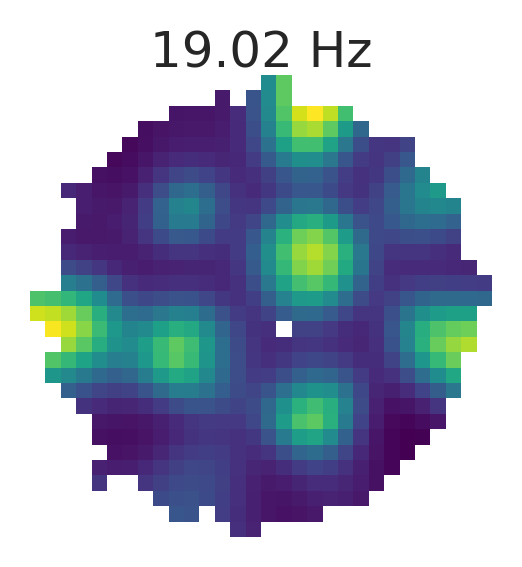

In [85]:
fig, ax = plt.subplots(figsize=(2,2))
cluid = "jp3129-04062022-0108_389"
plotmap(ax,cluid,myMaps)

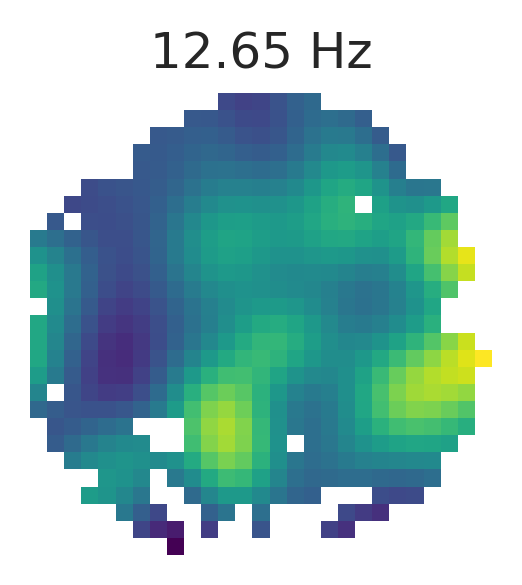

In [86]:
fig, ax = plt.subplots(figsize=(2,2))
cluid = "jp3129-04062022-0108_389"
plotLeverMap(ax,cluid,myLeverMaps,condition='all_dark',r='arenaref') #none, arenaref

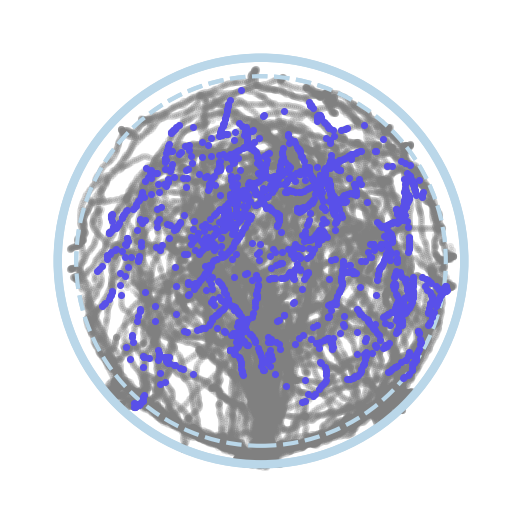

In [87]:
fig, ax = plt.subplots(figsize=(2,2))
cluid = "jp3129-04062022-0108_389"
spikeOnPathConditionRoomReference(ax,cluid,light = 'dark')

In [88]:
def plotRateLeverDistance(ax, myLeverHistos,cellIndex,light="all_light",title="",titleY=0.9,showXLabel=True,showTitle=True):
    """
    rate and occupancy histograms as a function of distance from lever
    """
    ax.plot(myLeverHistos[2], myLeverHistos[0][light][cellIndex],c='#ff7d00')
    ax.set_ylabel("Firing rate\n(Hz)",fontsize=GLOBALFONTSIZE)
    if showXLabel:
        ax.set_xlabel("Lever dist.",fontsize=GLOBALFONTSIZE)
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])
        ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0,12)
    
    peakRate = np.nanmax(myLeverHistos[0][light][cellIndex])
    ax.text(0.05,0.91,f'Peak rate:{round(peakRate,2)} Hz',fontsize=GLOBALFONTSIZE,transform=ax.transAxes)
    if showTitle:
        ax.set_title(title,y=titleY,fontsize=GLOBALFONTSIZE)
    else:
        ax.set_title('')

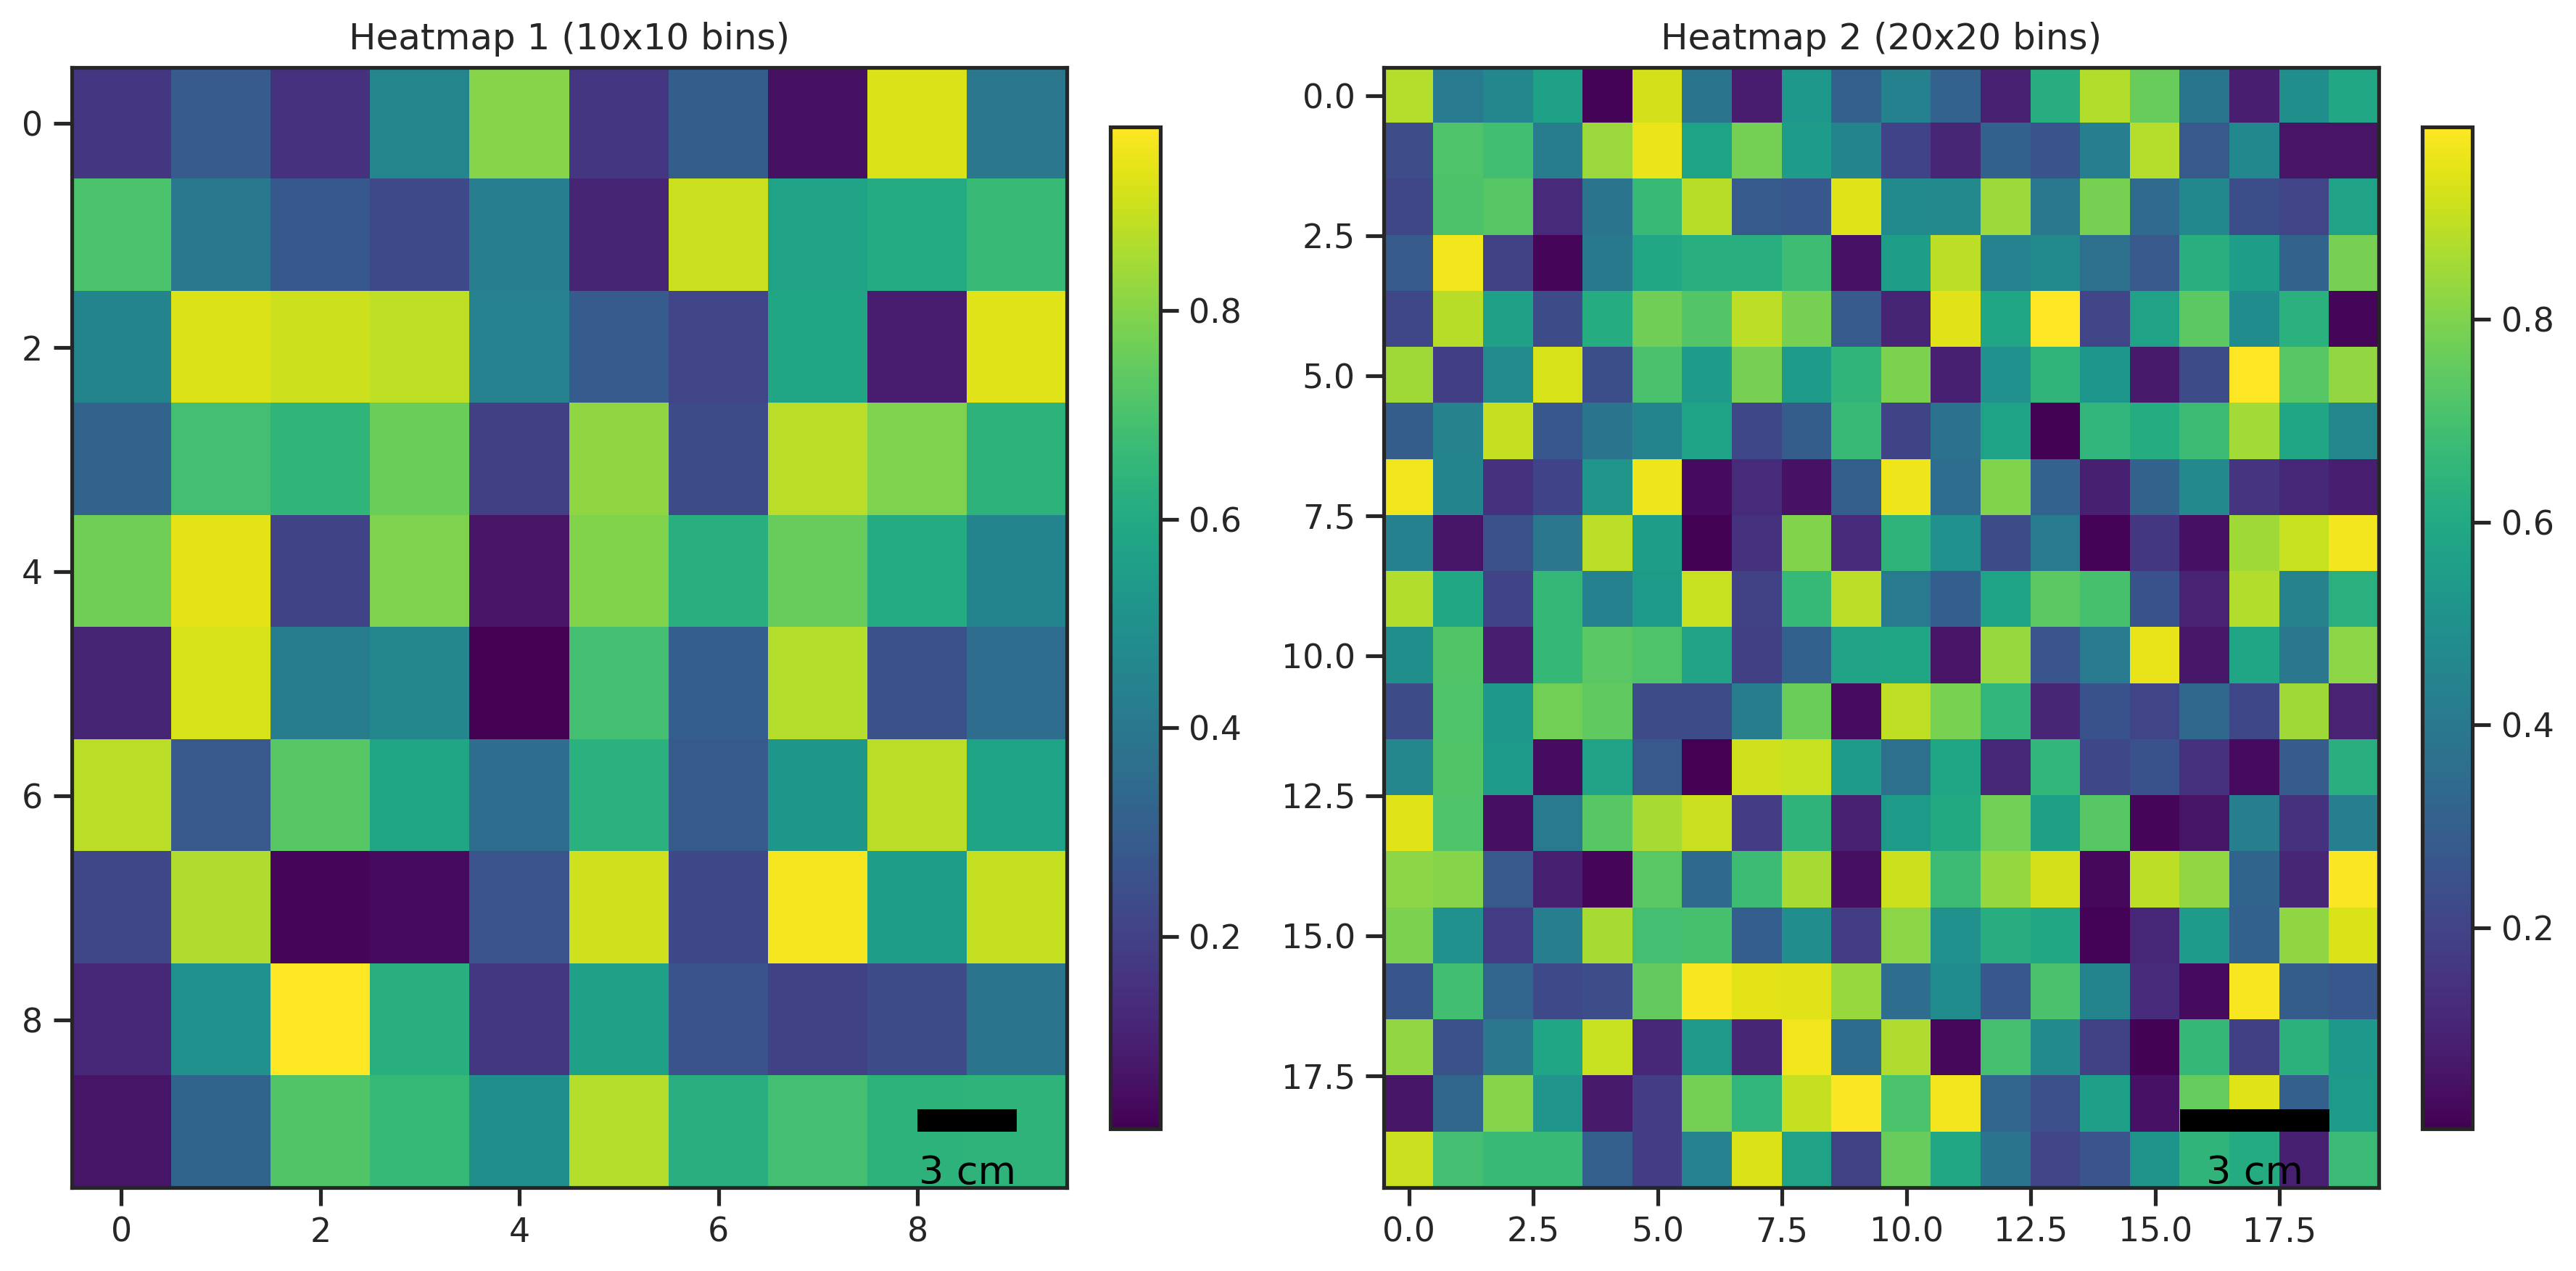

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

# Sample data for two heatmaps with different bin sizes
# Heatmap 1: 10x10 bins
data1 = np.random.rand(10, 10)
# Heatmap 2: 20x20 bins
data2 = np.random.rand(20, 20)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Heatmap 1
im1 = axes[0].imshow(data1, cmap='viridis', aspect='auto')
axes[0].set_title('Heatmap 1 (10x10 bins)')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Plot Heatmap 2
im2 = axes[1].imshow(data2, cmap='viridis', aspect='auto')
axes[1].set_title('Heatmap 2 (20x20 bins)')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# Function to add a scale bar
def add_scale_bar(ax, scale_length, height=0.02, color='black', label=None, loc='lower right', pad=0.05):
    """
    Adds a scale bar to a matplotlib axis.

    Parameters:
    - ax: The axis to add the scale bar to.
    - scale_length: The length of the scale bar in data units.
    - height: The height of the scale bar as a fraction of the axis height.
    - color: Color of the scale bar.
    - label: Optional label for the scale bar.
    - loc: Location code (e.g., 'lower right').
    - pad: Padding from the specified location.
    """
    # Get axis limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Determine position based on 'loc'
    if loc == 'lower right':
        x_start = xlim[1] - scale_length - (xlim[1] - xlim[0]) * pad
        y_start = ylim[0] + (ylim[1] - ylim[0]) * pad
    elif loc == 'lower left':
        x_start = xlim[0] + (xlim[1] - xlim[0]) * pad
        y_start = ylim[0] + (ylim[1] - ylim[0]) * pad
    elif loc == 'upper right':
        x_start = xlim[1] - scale_length - (xlim[1] - xlim[0]) * pad
        y_start = ylim[1] - (ylim[1] - ylim[0]) * pad - height * (ylim[1] - ylim[0])
    elif loc == 'upper left':
        x_start = xlim[0] + (xlim[1] - xlim[0]) * pad
        y_start = ylim[1] - (ylim[1] - ylim[0]) * pad - height * (ylim[1] - ylim[0])
    else:
        raise ValueError("Unsupported location. Use 'lower right', 'lower left', 'upper right', or 'upper left'.")

    # Add Rectangle patch as scale bar
    rect = Rectangle((x_start, y_start), scale_length, height * (ylim[1] - ylim[0]),
                     linewidth=0, edgecolor=None, facecolor=color, transform=ax.transData, zorder=10)
    ax.add_patch(rect)

    # Add label if provided
    if label:
        ax.text(x_start + scale_length / 2, y_start - (ylim[1] - ylim[0]) * 0.02,
                label, ha='center', va='top', color=color, transform=ax.transData,fontsize=GLOBALFONTSIZE-1)

# Define scale lengths for each heatmap (example values)
# Adjust these based on your actual bin sizes
scale_length1 = 1  # e.g., represents 2 units in Heatmap 1
scale_length2 = 3  # e.g., represents 1 unit in Heatmap 2

# Add scale bars to each heatmap
add_scale_bar(axes[0], scale_length=scale_length1, label='3 cm', loc='lower right')
add_scale_bar(axes[1], scale_length=scale_length2, label='3 cm', loc='lower right')

# Adjust layout and display
plt.tight_layout()
plt.show()


23 out of 24 are above the 95th percentile for atLever_dark
15 out of 24 are above the 95th percentile for atLever_light
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Middle_Lever vs. Middle_Room: Wilcoxon test (paired samples), P_val:4.335e-03 Stat=5.300e+01
Beg._Lever vs. Beg._Room: Wilcoxon test (paired samples), P_val:8.345e-06 Stat=1.200e+01
End_Lever vs. End_Room: Wilcoxon test (paired samples), P_val:1.260e-02 Stat=6.400e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Middle_Lever vs. Middle_Room: Wilcoxon test (paired samples), P_val:1.192e-07 Stat=0.000e+00
Beg._Lever vs. Beg._Room: Wilcoxon test (paired samples), P_val:1.192e-07 Stat=0.000e+00
End_Lever vs. End_Room: Wilcoxon test (paire

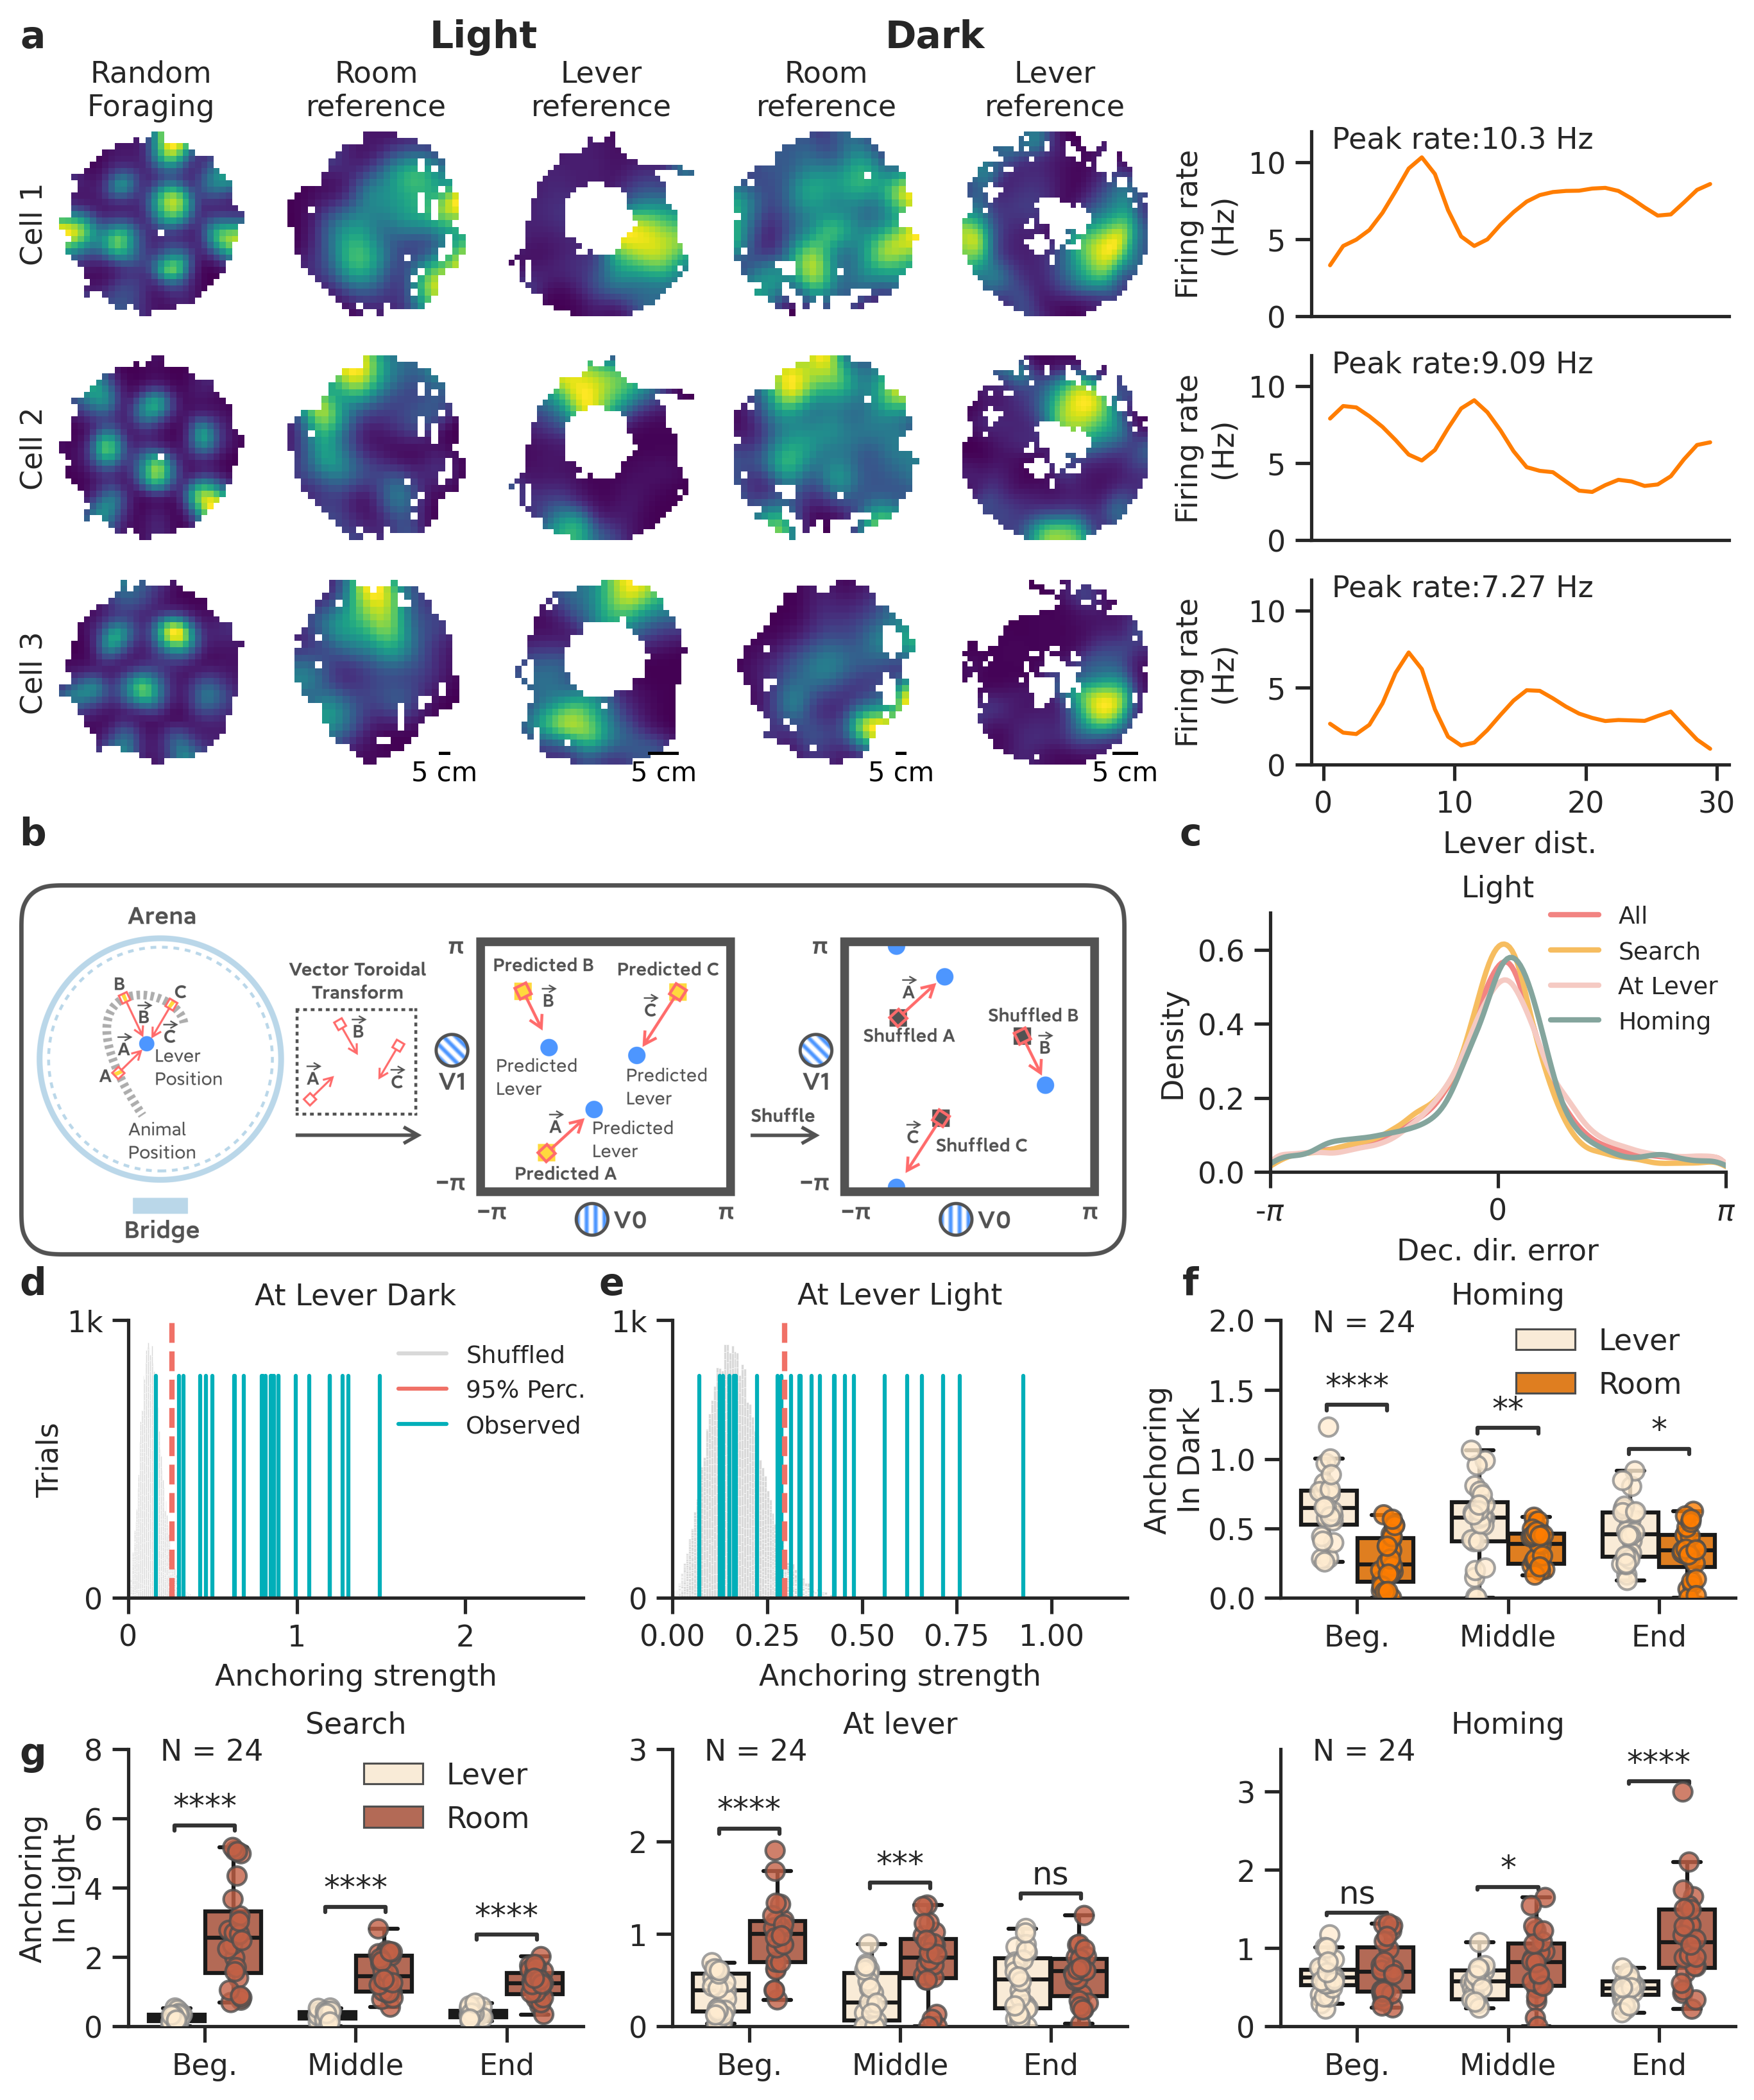

In [90]:
from matplotlib.image import imread
from PIL import Image

GLOBALFONTSIZE = 11

exampleNumber = 3

nrows = 6
ncols = 5
colSize = 1.8
rowSize = 1.8
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_theme(style = 'ticks')

def add_text(ax,x,y,label,fw = 'normal'):
    ax.text(x,y,label, style='normal', fontweight=fw, fontsize=GLOBALFONTSIZE+3,
                  verticalalignment='center', horizontalalignment='center', transform=ax.transAxes)
    
boxPlotColors = ['#ffecd1','#ff7d00','#15616d','#78290f'] #Lever First,
#Set the color for this figure


fig = plt.figure(figsize=(ncols*colSize,nrows*rowSize),constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig,height_ratios=[0.1,1,1,1,1,1])
gs1 = gridspec.GridSpecFromSubplotSpec(3,7,subplot_spec= gs[1:3,:])
gs2 = gridspec.GridSpecFromSubplotSpec(3,3,subplot_spec= gs[4:,:],height_ratios=[1,0.01,1])
gs4 = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec= gs[:,:])



ax0 = fig.add_subplot(gs4[:,:])


#Add labels for the different conditions
add_text(ax0,0.265,1,'Light',fw='bold')
add_text(ax0,0.53,1,'Dark',fw='bold')


#Add figure legend
add_text(ax0,0,1,'a',fw='bold')
add_text(ax0,0,0.61,'b',fw='bold')
add_text(ax0,0.68,0.61,'c',fw='bold')

add_text(ax0,0,0.39,'d',fw='bold')
add_text(ax0,0.34,0.39,'e',fw='bold')
add_text(ax0,0.68,0.39,'f',fw='bold')
add_text(ax0,0.0,0.16,'g',fw='bold')



ax0.axis('off')


#First Row
room_scale = 5/3
lever_scale = 5

####LEVER REF EXAMPLES######
ax0 = fig.add_subplot(gs1[0,0])
cellIdToPlot = 'jp3129-04062022-0108_389'
plotmap(ax0,cellIdToPlot,myMaps)
ax0.set_title('Random\nForaging', fontsize=GLOBALFONTSIZE)
ax0.set_ylabel('Cell 1', fontsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs1[0,1])
plotLeverMap(ax0,cellIdToPlot,myLeverMaps,condition='all_light',r='arenaref') #none, arenaref
ax0.set_title('Room\nreference', fontsize=GLOBALFONTSIZE)


ax0 = fig.add_subplot(gs1[0,2])
plotLeverMap(ax0,cellIdToPlot,myLeverMaps,condition='all_light',r='none') #none, arenaref
ax0.set_title('Lever\nreference', fontsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs1[0,3])
plotLeverMap(ax0,cellIdToPlot,myLeverMaps,condition='all_dark',r='arenaref') #none, arenaref
ax0.set_title('Room\nreference', fontsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs1[0,4])
plotLeverMap(ax0,cellIdToPlot,myLeverMaps,condition='all_dark',r='none') #none, arenaref
ax0.set_title('Lever\nreference', fontsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs1[0,5:])
cellIndex = cells[cells.cluId==cellIdToPlot].index.item()
plotRateLeverDistance(ax0,myLeverHistos,cellIndex,light='all_dark',showXLabel=False)

ax0 = fig.add_subplot(gs1[1,0])
cellIdToPlot = 'jp3129-04062022-0108_340'
plotmap(ax0,cellIdToPlot,myMaps)
ax0.set_title('')
ax0.set_ylabel('Cell 2', fontsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs1[1,1])
plotLeverMap(ax0,cellIdToPlot,myLeverMaps,condition='all_light',r='arenaref') #none, arenaref
ax0.set_title('')

ax0 = fig.add_subplot(gs1[1,2])
plotLeverMap(ax0,cellIdToPlot,myLeverMaps,condition='all_light',r='none') #none, arenaref
ax0.set_title('')

ax0 = fig.add_subplot(gs1[1,3])
plotLeverMap(ax0,cellIdToPlot,myLeverMaps,condition='all_dark',r='arenaref') #none, arenaref
ax0.set_title('')

ax0 = fig.add_subplot(gs1[1,4])
plotLeverMap(ax0,cellIdToPlot,myLeverMaps,condition='all_dark',r='none') #none, arenaref
ax0.set_title('')

ax0 = fig.add_subplot(gs1[1,5:])
cellIndex = cells[cells.cluId==cellIdToPlot].index.item()
plotRateLeverDistance(ax0,myLeverHistos,cellIndex,light='all_dark',showXLabel=False,showTitle=False)

ax0 = fig.add_subplot(gs1[2,0])
cellIdToPlot = 'jp1686-29042022-0109_229'
plotmap(ax0,cellIdToPlot,myMaps)
ax0.set_title('')
ax0.set_ylabel('Cell 3', fontsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs1[2,1])
plotLeverMap(ax0,cellIdToPlot,myLeverMaps,condition='all_light',r='arenaref') #none, arenaref
ax0.set_title('')
ax0.set_xlabel('',fontsize= GLOBALFONTSIZE)
add_scale_bar(ax0, scale_length=room_scale, label='5 cm', loc='lower right')

ax0 = fig.add_subplot(gs1[2,2])
plotLeverMap(ax0,cellIdToPlot,myLeverMaps,condition='all_light',r='none') #none, arenaref
ax0.set_xlabel('',fontsize= GLOBALFONTSIZE)
ax0.set_title('')
add_scale_bar(ax0, scale_length=lever_scale, label='5 cm', loc='lower right')

ax0 = fig.add_subplot(gs1[2,3])
plotLeverMap(ax0,cellIdToPlot,myLeverMaps,condition='all_dark',r='arenaref') #none, arenaref
ax0.set_xlabel('',fontsize= GLOBALFONTSIZE)
ax0.set_title('')
add_scale_bar(ax0, scale_length=room_scale, label='5 cm', loc='lower right')

ax0 = fig.add_subplot(gs1[2,4])
plotLeverMap(ax0,cellIdToPlot,myLeverMaps,condition='all_dark',r='none') #none, arenaref
ax0.set_xlabel('',fontsize= GLOBALFONTSIZE)
ax0.set_title('')
add_scale_bar(ax0, scale_length=lever_scale, label='5 cm', loc='lower right')


ax0 = fig.add_subplot(gs1[2,5:])
cellIndex = cells[cells.cluId==cellIdToPlot].index.item()
plotRateLeverDistance(ax0,myLeverHistos,cellIndex,light='all_dark',showTitle=False)

####LEVER REF EXAMPLES######


#Third Row
gs5_IMG = gridspec.GridSpecFromSubplotSpec(1,6,subplot_spec= gs[3,:],width_ratios=[1]*4+[1.1]*2)

ax0 = fig.add_subplot(gs5_IMG[0,:4])
image = Image.open('leverPred2.png')
ax0.imshow(image)
ax0.axis('off')

gs5 = gridspec.GridSpecFromSubplotSpec(1,6,subplot_spec= gs[3,:],width_ratios=[1]*4+[0.8]*2)

ax0 = fig.add_subplot(gs5[0,4:])
plot_histogram_per_condition(ax0,histoDf,'light',colorList=['#F28482','#F6BD60','#F5CAC3','#84A59D'],noYaxis=False,title='Light',legendX=0.8,legendY=0.45,xlabel='Dec. dir. error')

ax = fig.add_subplot(gs2[0,0])
get_shuffle_map(ax,condition='atLever_dark',title='At Lever Dark',customLegend=True,xlim=2.7,ylabel='Trials')
ax = fig.add_subplot(gs2[0,1])
get_shuffle_map(ax,condition='atLever_light',title='At Lever Light',xlim=1.2,customLegend=False)




ax0 = fig.add_subplot(gs2[0,2])
light = 'Dark'
condition = 'Homing' 
inputDf = dfAnchor[(dfAnchor.shortCondition==condition)&(dfAnchor.light==light)]

plot_anchoring_strength_box(ax0,inputDf, ylabel = 'Anchoring\nIn Dark', title='Homing',ylim=2,legendY=0.62,titleName='Homing')


ax0 = fig.add_subplot(gs2[2,0])
light = 'Light'
condition = 'Search' 
inputDf = dfAnchor[(dfAnchor.shortCondition==condition)&(dfAnchor.light==light)]
plot_anchoring_strength_box(ax0,inputDf, ylabel = 'Anchoring\nIn Light',title='',legend=True,ylim=8,titleName='Search',pal=['#ffecd1','#c36146'])

ax0 = fig.add_subplot(gs2[2,1])
light = 'Light'
condition = 'Lever' 
inputDf = dfAnchor[(dfAnchor.shortCondition==condition)&(dfAnchor.light==light)]
plot_anchoring_strength_box(ax0,inputDf,title='At lever',legend=False,ylim=3,titleName='At lever',pal=['#ffecd1','#c36146'])

ax0 = fig.add_subplot(gs2[2,2])
light = 'Light'
condition = 'Homing' 
inputDf = dfAnchor[(dfAnchor.shortCondition==condition)&(dfAnchor.light==light)]
plot_anchoring_strength_box(ax0,inputDf, title='Homing',legend=False,ylim=1.7,titleName='Homing',pal=['#ffecd1','#c36146'])